# Estimate Extended Model with OMP using Dream on SLURM 
## Basics
- Using Dream 20 000 iterations

In [1]:
TITLE = "corpus_omp_estim_log"

In [2]:
import shutil
import sys
import pickle
import glob
from collections import OrderedDict
import numpy as np
from scenewalk.scenewalk_model_object import scenewalk as scenewalk_obj
from matplotlib import pyplot as plt
from scenewalk.simulation import simulate_dataset
from scenewalk.utils import utils
from scenewalk.utils.utils import trpd as trpd
from scipy.stats import norm as normal, truncnorm as truncated_normal
import seaborn as sns
from scipy import stats
from pymc3.stats import hpd
import random
from scenewalk.plotting import nb_plots
import matplotlib.patches as mpatches
import re
import pandas as pd
from scenewalk.utils import loadData

In [3]:
datadict = loadData.load_data("corpus_training")
#datadict = loadData.chop_scanpaths(1, 18, datadict)
#datadict_short = loadData.shorten_set(datadict, 10, list(range(10)))
x_dat, y_dat, dur_dat, im_dat, densities_dat, d_range = loadData.dataDict2vars(datadict)

In [4]:
len(x_dat)

35

## CHopification

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0., 33.]),
 array([30., 33., 36., 39., 42., 45., 48., 51., 54., 57., 60.]),
 <a list of 10 Patch objects>)

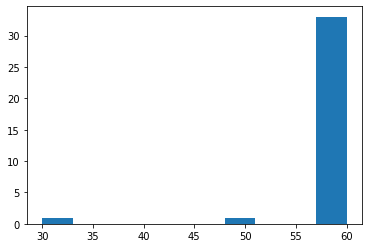

In [5]:
qq = [len(i) for i in x_dat]
plt.hist(qq)
#qq

In [6]:
lll = []
for subj in x_dat:
    subl = [len(i) for i in subj]
    lll.extend(subl)

(array([  5.,   4.,  30., 167., 322., 544., 648., 235.,  79.,  24.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <a list of 10 Patch objects>)

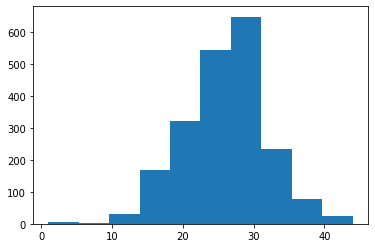

In [7]:
plt.hist(lll)

## Save the model

In [8]:
reset_model = False
if reset_model:
    kwargs_d = {"coupled_oms": True, "saclen_shift":True, "coupled_facil":True, "omp":"add", "logged_z":True, "logged_ompf":True}
    sw_args = ['subtractive', 'cb','both', 1, 'on', {'x': d_range[0], 'y': d_range[1]}, kwargs_d]
    np.save("sw_args.npy", sw_args)
else:
    sw_args = np.load("sw_args.npy", allow_pickle=True)        

print(np.load("sw_args.npy", allow_pickle=True))
sw = scenewalk_obj(*sw_args)

['subtractive' 'cb' 'both' 1 'on'
 {'x': array([ 1.03585769, 32.1115885 ]), 'y': array([ 0.82868615, 25.6892708 ])}
 {'coupled_oms': True, 'saclen_shift': True, 'coupled_facil': True, 'omp': 'add', 'logged_z': True, 'logged_ompf': True}]


In [9]:
sw.whoami()

'I am a subtractive scenewalk model, initialized with cb activation, in 1 exponents mode, using a presaccadic shift, using a postsaccadic shift, using location dependent attention decay, with om_i as a fraction, with coupled facilitation, with logged z, with eta=saclen, with omplogged'

In [10]:
print(sw.coupled_oms)
sw.get_param_list_order()

True


['omegaAttention',
 'omfrac',
 'sigmaAttention',
 'sigmaInhib',
 'gamma',
 'inhibStrength',
 'zeta',
 'sigmaShift',
 'shift_size',
 'first_fix_OmegaAttention',
 'cb_sd_x',
 'cb_sd_y',
 'omega_prevloc_frac',
 'chi',
 'ompfactor']

In [11]:
sw.update_params([1,2,3,4,5,6,-7,8,9,10,11,12,13,14,-20])
print(sw.get_params())
sw.check_params_in_bounds()

OrderedDict([('omegaAttention', 1), ('omegaInhib', 0.5), ('sigmaAttention', 3), ('sigmaInhib', 4), ('gamma', 5), ('inhibStrength', 6), ('zeta', 1e-07), ('sigmaShift', 8), ('shift_size', 9), ('first_fix_OmegaAttention', 10), ('cb_sd_x', 11), ('cb_sd_y', 12), ('omega_prevloc', 0.07692307692307693), ('chi', 14), ('ompfactor', 1e-20)])


False

In [12]:
sw.clear_params()

In [13]:
zeta_range = (10 ** -20, 0)
zeta_range

(1e-20, 0)

In [14]:
zeta_range[0] <= 10**-7 <= zeta_range[1]

False

## Set Priors

In [15]:
reset_priors = False
if reset_priors:
    prior_args = OrderedDict({
        "omegaAttention" : [8, 11, np.finfo(np.float64).eps, 100],
        #"omegaInhib" :  [7, 130, np.finfo(np.float64).eps, 100],
        "sigmaAttention" : [6, 5, np.finfo(np.float64).eps, 30],
        "sigmaInhib" :  [4, 4, np.finfo(np.float64).eps, 30],
        "gamma" :  [1, 3, np.finfo(np.float64).eps, 5],
        #"lamb" :  [1, 10, np.finfo(np.float64).eps, 5],
        #"inhibStrength" : [0.3, 1, np.finfo(np.float64).eps, 2],
        "zeta" : [-2, 1, -5, 0],
        #'sigmaShift': [4, 70, np.finfo(np.float64).eps, 30],
        'shift_size': [0.5, 2, np.finfo(np.float64).eps, 3],
        'ompfactor': [-1.2, 1, -5, 0],
    })
    np.save("priors.npy", prior_args)
else: 
    prior_args = np.load("priors.npy", allow_pickle=True).item()

In [16]:
priors = OrderedDict()
for p in prior_args.keys():
    priors[p] = trpd(*prior_args[p])

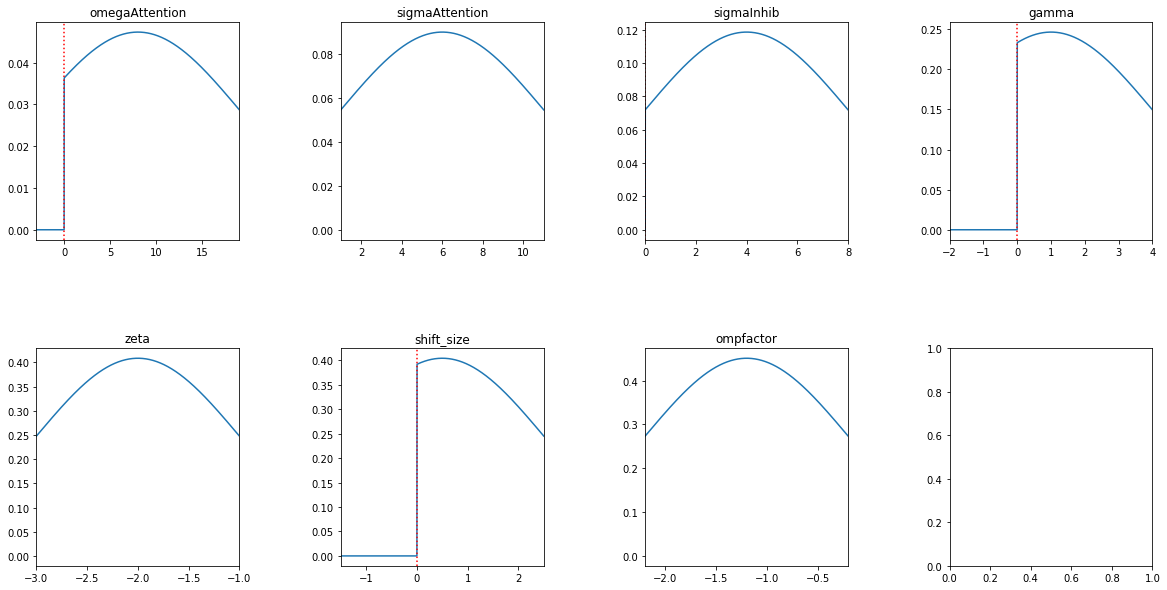

In [17]:
fig, ax = nb_plots.priors_plot(priors)

## Set default values (for when not simulating all)

In [18]:
reset_def = False
if reset_def:
    def_args = OrderedDict({
        'omegaAttention': None,
        'omfrac': 10,
        'sigmaAttention': None,
        "sigmaInhib" : None,
        'gamma': None,
        #"lamb":None,
        'inhibStrength': 0.3,
        'zeta': None,
        'sigmaShift': 2,
        'shift_size': None,
        'first_fix_OmegaAttention':1.5,
        'cb_sd_x':4,
        'cb_sd_y':3,
        'omega_prevloc_frac':10,
        'chi':0.1,
        'ompfactor': None,
    })
    np.save("defaults.npy", def_args)

In [19]:
def_args = np.load("defaults.npy", allow_pickle=True).item()
print(np.load("defaults.npy", allow_pickle=True))

OrderedDict([('omegaAttention', None), ('omfrac', 10), ('sigmaAttention', None), ('sigmaInhib', None), ('gamma', None), ('inhibStrength', 0.3), ('zeta', None), ('sigmaShift', 2), ('shift_size', None), ('first_fix_OmegaAttention', 1.5), ('cb_sd_x', 4), ('cb_sd_y', 3), ('omega_prevloc_frac', 10), ('chi', 0.1), ('ompfactor', None)])


In [20]:
utils.check_param_dict_order(def_args, sw)

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

## Estimate with PyDream
run run_dream.py on cluster. Takes a long time!

In [21]:
all_vp_list = list(range(35))

In [22]:
vp_list = [random.choice(all_vp_list) for _ in range(5)]
vp_list = [27, 10, 34, 0, 5]
vp_list

[27, 10, 34, 0, 5]

In [23]:
estim_id = "202002"

## Check Results

In [24]:
credible_interval=0.5

In [25]:
chains_path_list = glob.glob("./estim_"+estim_id+"*/"+estim_id+"*_chains.npy")
#meta_list = glob.glob("./estim_"+estim_id+"*/"+estim_id+"*_meta.npy")
#meta_list
chains_path_list

['./estim_20200224-105042vp6/20200224-105042vp6_estim_chains.npy',
 './estim_20200224-105042vp1/20200224-105042vp1_estim_chains.npy',
 './estim_20200224-105042vp8/20200224-105042vp8_estim_chains.npy',
 './estim_20200224-105042vp31/20200224-105042vp31_estim_chains.npy',
 './estim_20200224-105042vp9/20200224-105042vp9_estim_chains.npy',
 './estim_20200224-105042vp0/20200224-105042vp0_estim_chains.npy',
 './estim_20200224-105042vp7/20200224-105042vp7_estim_chains.npy',
 './estim_20200224-105042vp30/20200224-105042vp30_estim_chains.npy',
 './estim_20200224-105042vp12/20200224-105042vp12_estim_chains.npy',
 './estim_20200224-105042vp23/20200224-105042vp23_estim_chains.npy',
 './estim_20200224-105042vp24/20200224-105042vp24_estim_chains.npy',
 './estim_20200224-105042vp25/20200224-105042vp25_estim_chains.npy',
 './estim_20200224-105042vp22/20200224-105042vp22_estim_chains.npy',
 './estim_20200224-105042vp13/20200224-105042vp13_estim_chains.npy',
 './estim_20200224-105042vp32/20200224-105042v

In [26]:
chains_path_list_sorted = [None for el in range(max(all_vp_list)+1)]
i=0
for p in chains_path_list:
    print(p)
    i+=1
    mat = re.search(r"vp([0-9]*)\/", p)
    vpnr = int(mat.group(1))
    print(vpnr)
    chains_path_list_sorted[vpnr]=p
chains_path_list_sorted

./estim_20200224-105042vp6/20200224-105042vp6_estim_chains.npy
6
./estim_20200224-105042vp1/20200224-105042vp1_estim_chains.npy
1
./estim_20200224-105042vp8/20200224-105042vp8_estim_chains.npy
8
./estim_20200224-105042vp31/20200224-105042vp31_estim_chains.npy
31
./estim_20200224-105042vp9/20200224-105042vp9_estim_chains.npy
9
./estim_20200224-105042vp0/20200224-105042vp0_estim_chains.npy
0
./estim_20200224-105042vp7/20200224-105042vp7_estim_chains.npy
7
./estim_20200224-105042vp30/20200224-105042vp30_estim_chains.npy
30
./estim_20200224-105042vp12/20200224-105042vp12_estim_chains.npy
12
./estim_20200224-105042vp23/20200224-105042vp23_estim_chains.npy
23
./estim_20200224-105042vp24/20200224-105042vp24_estim_chains.npy
24
./estim_20200224-105042vp25/20200224-105042vp25_estim_chains.npy
25
./estim_20200224-105042vp22/20200224-105042vp22_estim_chains.npy
22
./estim_20200224-105042vp13/20200224-105042vp13_estim_chains.npy
13
./estim_20200224-105042vp32/20200224-105042vp32_estim_chains.npy
3

['./estim_20200224-105042vp0/20200224-105042vp0_estim_chains.npy',
 './estim_20200224-105042vp1/20200224-105042vp1_estim_chains.npy',
 './estim_20200224-105042vp2/20200224-105042vp2_estim_chains.npy',
 './estim_20200224-105042vp3/20200224-105042vp3_estim_chains.npy',
 './estim_20200224-105042vp4/20200224-105042vp4_estim_chains.npy',
 './estim_20200224-105042vp5/20200224-105042vp5_estim_chains.npy',
 './estim_20200224-105042vp6/20200224-105042vp6_estim_chains.npy',
 './estim_20200224-105042vp7/20200224-105042vp7_estim_chains.npy',
 './estim_20200224-105042vp8/20200224-105042vp8_estim_chains.npy',
 './estim_20200224-105042vp9/20200224-105042vp9_estim_chains.npy',
 './estim_20200224-105042vp10/20200224-105042vp10_estim_chains.npy',
 './estim_20200224-105042vp11/20200224-105042vp11_estim_chains.npy',
 './estim_20200224-105042vp12/20200224-105042vp12_estim_chains.npy',
 './estim_20200224-105042vp13/20200224-105042vp13_estim_chains.npy',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 './e

In [27]:
chains_path_list_sorted

['./estim_20200224-105042vp0/20200224-105042vp0_estim_chains.npy',
 './estim_20200224-105042vp1/20200224-105042vp1_estim_chains.npy',
 './estim_20200224-105042vp2/20200224-105042vp2_estim_chains.npy',
 './estim_20200224-105042vp3/20200224-105042vp3_estim_chains.npy',
 './estim_20200224-105042vp4/20200224-105042vp4_estim_chains.npy',
 './estim_20200224-105042vp5/20200224-105042vp5_estim_chains.npy',
 './estim_20200224-105042vp6/20200224-105042vp6_estim_chains.npy',
 './estim_20200224-105042vp7/20200224-105042vp7_estim_chains.npy',
 './estim_20200224-105042vp8/20200224-105042vp8_estim_chains.npy',
 './estim_20200224-105042vp9/20200224-105042vp9_estim_chains.npy',
 './estim_20200224-105042vp10/20200224-105042vp10_estim_chains.npy',
 './estim_20200224-105042vp11/20200224-105042vp11_estim_chains.npy',
 './estim_20200224-105042vp12/20200224-105042vp12_estim_chains.npy',
 './estim_20200224-105042vp13/20200224-105042vp13_estim_chains.npy',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 './e

In [28]:
chains_list = []
for p in chains_path_list_sorted:
    print(p)
    if p is None:
        chains_list.append(None)
        continue
    chain = np.load(p)
    chains_list.append(chain)
#chains_list.insert(31, None)

./estim_20200224-105042vp0/20200224-105042vp0_estim_chains.npy
./estim_20200224-105042vp1/20200224-105042vp1_estim_chains.npy
./estim_20200224-105042vp2/20200224-105042vp2_estim_chains.npy
./estim_20200224-105042vp3/20200224-105042vp3_estim_chains.npy
./estim_20200224-105042vp4/20200224-105042vp4_estim_chains.npy
./estim_20200224-105042vp5/20200224-105042vp5_estim_chains.npy
./estim_20200224-105042vp6/20200224-105042vp6_estim_chains.npy
./estim_20200224-105042vp7/20200224-105042vp7_estim_chains.npy
./estim_20200224-105042vp8/20200224-105042vp8_estim_chains.npy
./estim_20200224-105042vp9/20200224-105042vp9_estim_chains.npy
./estim_20200224-105042vp10/20200224-105042vp10_estim_chains.npy
./estim_20200224-105042vp11/20200224-105042vp11_estim_chains.npy
./estim_20200224-105042vp12/20200224-105042vp12_estim_chains.npy
./estim_20200224-105042vp13/20200224-105042vp13_estim_chains.npy
None
None
None
None
None
None
None
./estim_20200224-105042vp21/20200224-105042vp21_estim_chains.npy
./estim_20

## save estimates and restructure data

In [29]:
overall_params = utils.save2dict_overall_point_estimates(chains_list, all_vp_list, def_args, priors, sw, credible_interval, "average_estimates.npy", perc_last_samples=75)

omegaAttention
sigmaAttention
sigmaInhib
gamma
zeta
shift_size
ompfactor


In [30]:
overall_params

{'omegaAttention': 10.34917166639562,
 'omfrac': 10,
 'sigmaAttention': 7.242574302411814,
 'sigmaInhib': 6.707533523113416,
 'gamma': 0.9652265431114555,
 'inhibStrength': 0.3,
 'zeta': -1.7840781177159666,
 'sigmaShift': 2,
 'shift_size': 0.4548333108575958,
 'first_fix_OmegaAttention': 1.5,
 'cb_sd_x': 4,
 'cb_sd_y': 3,
 'omega_prevloc_frac': 10,
 'chi': 0.1,
 'ompfactor': -0.6157217460694778}

In [31]:
#Samples to dictionary
vp_params = utils.save2dict_by_subj(chains_list, all_vp_list, def_args, "sample_dict.npy", perc_last_samples=75)

In [32]:
#Point estimates without CI
vp_params = utils.save2npy_point_estimate_by_subj(chains_list, all_vp_list, def_args, credible_interval, "estim_"+estim_id+"param_mpde", CI=False)

In [33]:
#Point estimates with CI
vp_params = utils.save2npy_point_estimate_by_subj(chains_list, all_vp_list, def_args, credible_interval, "estim_"+estim_id+"param_mpde_conf", CI=True)

In [34]:
chainsdict = utils.save2dict_by_subj(chains_list, all_vp_list, def_args, "sample_dict.npy", perc_last_samples=75)
hpde_overall = utils.save2pd_overall_point_estimates(chains_list, all_vp_list, def_args, priors, sw, credible_interval, "average_estimates.csv", perc_last_samples=75)
hpde_subj = utils.save2pd_subj_point_estimates(chains_list, all_vp_list, priors, credible_interval, "pd_by_vp.csv")

omegaAttention
sigmaAttention
sigmaInhib
gamma
zeta
shift_size
ompfactor


In [35]:
hpde_overall

param_name       mpde    interv      left      right
0             omegaAttention  10.349172  2.622126  7.727046  12.971298
1                     omfrac  10.000000       NaN       NaN        NaN
2             sigmaAttention   7.242574  1.015062  6.227512   8.257637
3                 sigmaInhib   6.707534  2.724186  3.983347   9.431720
4                      gamma   0.965227  0.102286  0.862940   1.067513
5              inhibStrength   0.300000       NaN       NaN        NaN
6                       zeta  -1.784078  0.249037 -2.033115  -1.535041
7                 sigmaShift   2.000000       NaN       NaN        NaN
8                 shift_size   0.454833  0.080632  0.374201   0.535466
9   first_fix_OmegaAttention   1.500000       NaN       NaN        NaN
10                   cb_sd_x   4.000000       NaN       NaN        NaN
11                   cb_sd_y   3.000000       NaN       NaN        NaN
12        omega_prevloc_frac  10.000000       NaN       NaN        NaN
13                       chi   0.100000       NaN       NaN        NaN
14                 ompfactor  -0.615722  0.213925 -0.829647  -0.401797
15                   tau_pre        NaN       NaN       NaN        NaN
16                  tau_post        NaN       NaN       NaN        NaN
17                  foR_size        NaN       NaN       NaN        NaN
18                       chi        NaN       NaN       NaN        NaN
19                       psi        NaN       NaN       NaN        NaN

In [37]:
p_names_formatted = {
    "omegaAttention": r'$\omega_A$', 
    "sigmaAttention": r'$\sigma_A$', 
    "sigmaInhib": r'$\sigma_I$', 
    "gamma" : r'$\gamma$', 
    "zeta": r'$\zeta$', 
    "sigmaShift" : r'$\sigma_{post}$', 
    "shift_size" : r'$\eta$',
    "inhibStrength":"CF",
    "ompfactor":r'$\psi$'
    #"shift_size":"shift_size"
}

In [37]:
vp_params

OrderedDict([(0,
              OrderedDict([('omegaAttention',
                            [23.00493907643054, 1.4811426195053414]),
                           ('omfrac', 10),
                           ('sigmaAttention',
                            [8.903240301488157, 0.28265213276616485]),
                           ('sigmaInhib',
                            [8.808744811314286, 0.9164772303703259]),
                           ('gamma',
                            [0.9142627041941578, 0.03325378814990787]),
                           ('inhibStrength', 0.3),
                           ('zeta',
                            [-1.5387555816482208, 0.14753024848371887]),
                           ('sigmaShift', 2),
                           ('shift_size',
                            [0.5118234040277879, 0.023284568290819263]),
                           ('first_fix_OmegaAttention', 1.5),
                           ('cb_sd_x', 4),
                           ('cb_sd_y', 3),
                 

## PLOT

In [38]:
chains = chains_list[0]
nruns, niter, nparams = chains.shape

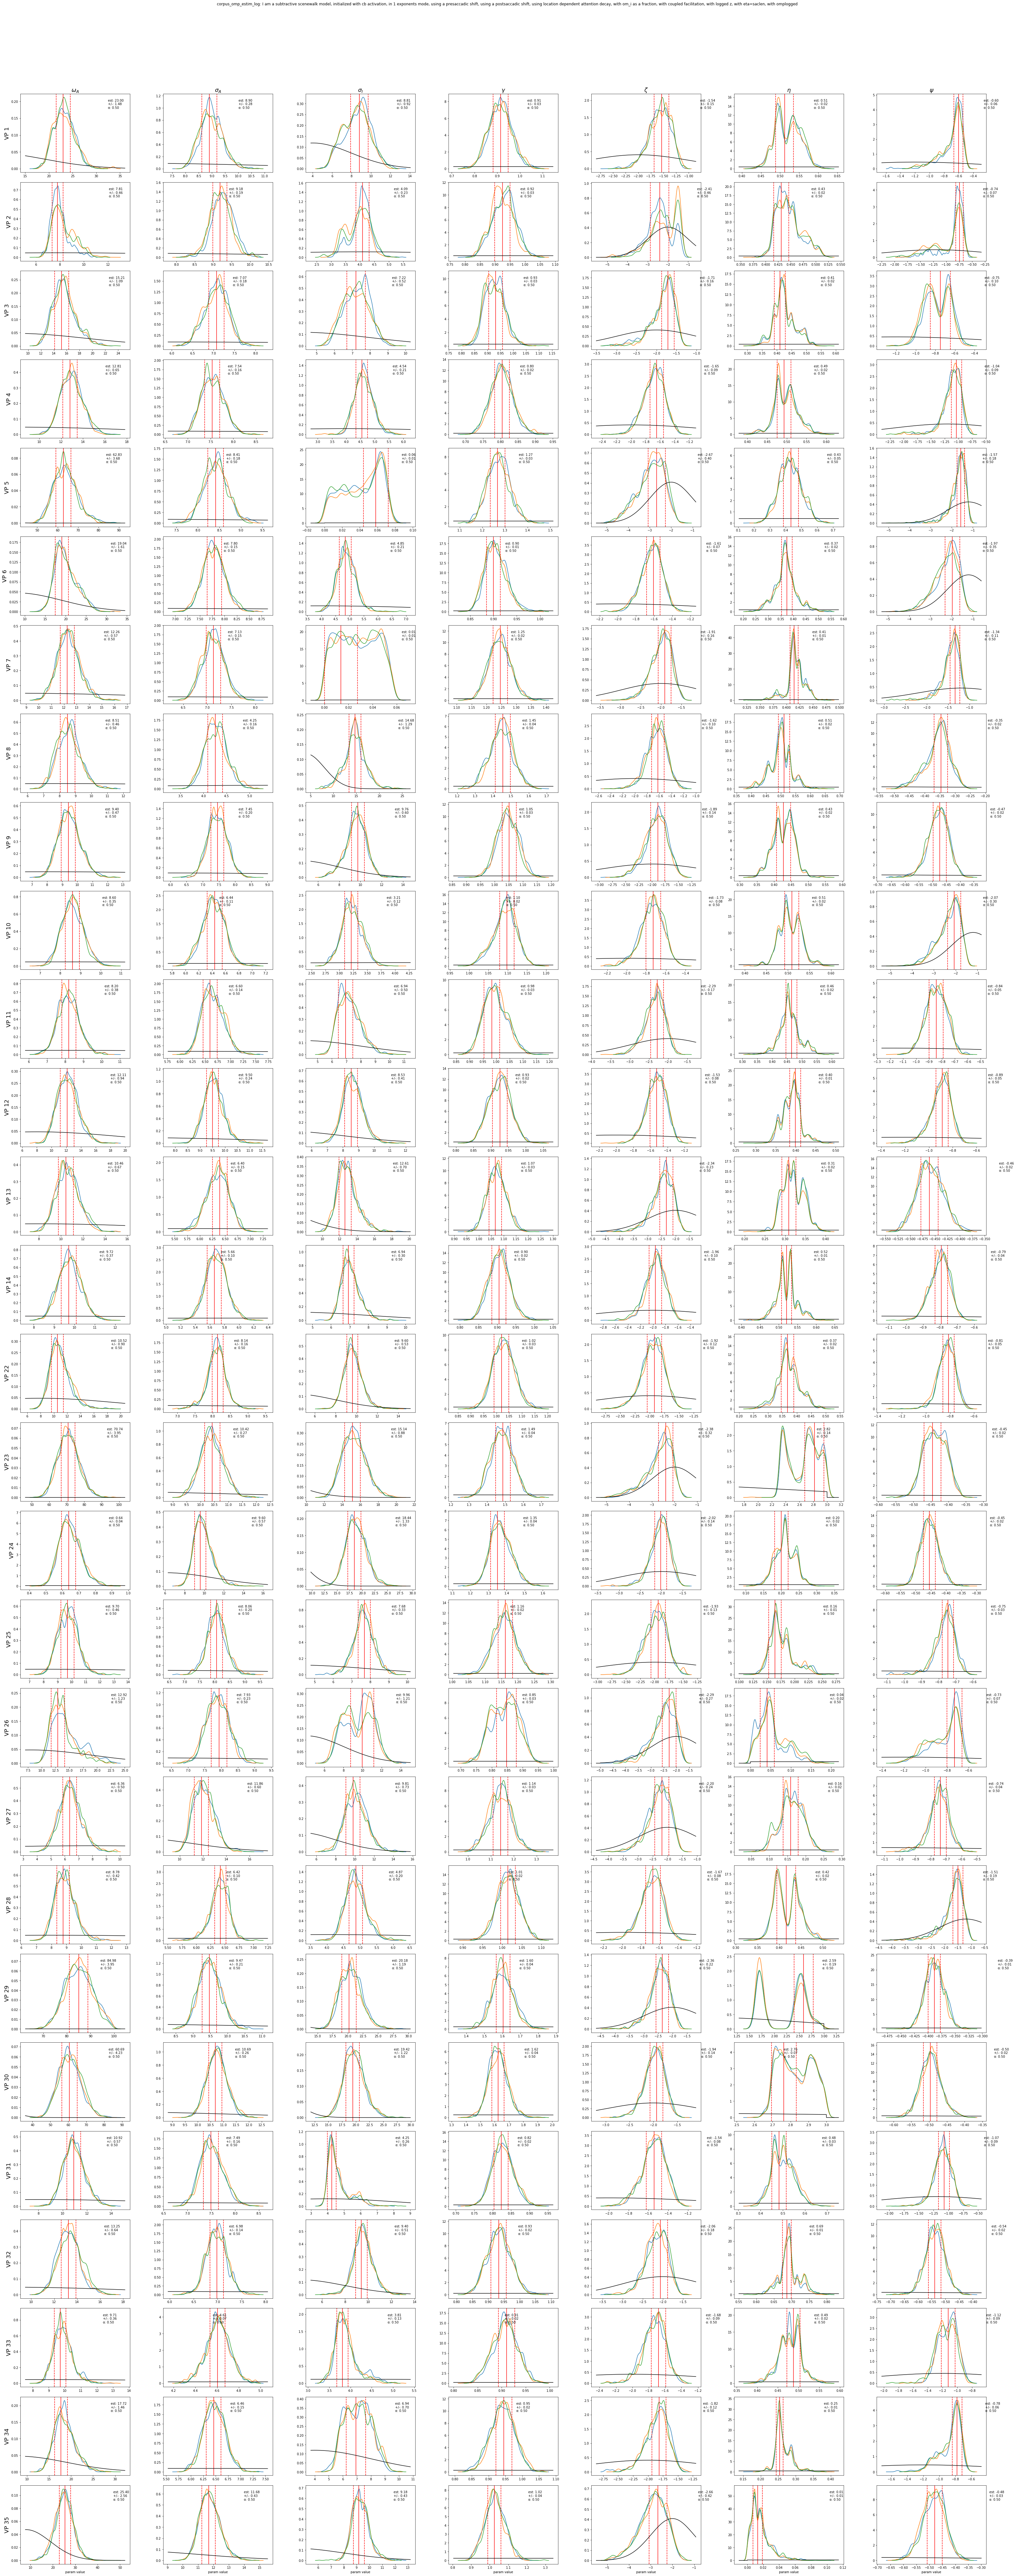

In [39]:
nrow = len(vp_list) #vps
ncol = 7 #params
plot_all_sub = False
if plot_all_sub:
    vp_list2 = vp_list
    vp_list = all_vp_list
    vp_list = list(vp_params.keys())
    nrow = len(vp_list) #vps
    fig, ax = plt.subplots(nrow, ncol, figsize=(45, 120))
else:
    fig, ax = plt.subplots(nrow, ncol, figsize=(45, 20))    


fig.suptitle(TITLE + ": " + sw.whoami())
ax = ax.ravel()

plt_idx = 0
row_idx = 0
for vp in vp_list:
    
    chains = chains_list[vp]
#for chains in chains_list:
    param_ix = 0
    for param_name in list(priors.keys()):
        # Set up Row and column names
        if row_idx == 0:
            p_name = p_names_formatted[param_name]
            ax[plt_idx].set_title(p_name, fontsize=18)
        if row_idx == nrow-1:
            ax[plt_idx].set_xlabel("param value")
        if param_name == list(priors.keys())[0]:
            ax[plt_idx].set_ylabel("VP "+ str(vp_list[row_idx]+1), fontsize=18)
        if chains is None:            
            plt_idx += 1
            param_ix += 1
            continue
            
        # Plot Chains
        chain1 = chains[0,5000:,param_ix]
        chain2 = chains[1,5000:,param_ix]
        chain3 = chains[2,5000:,param_ix]
        
        sns.distplot(chain1, hist=False, ax=ax[plt_idx])
        sns.distplot(chain2, hist=False, ax=ax[plt_idx])
        sns.distplot(chain3, hist=False, ax=ax[plt_idx])
        
        # Highst Posterior Density
        allchains = np.hstack((chain1, chain2, chain3))
        hpd_all = hpd(allchains, credible_interval)
        mpde = (hpd_all[1]+hpd_all[0])/2
        ax[plt_idx].axvline(x=hpd_all[0], c="red", linestyle="--")
        ax[plt_idx].axvline(x=hpd_all[1], c="red", linestyle="--")
        ax[plt_idx].axvline(x=mpde, c="red", linestyle="-")

        # Text Info About estimate (positioning and printing)
        max_y = ax[plt_idx].get_ylim()[1] - 0.2*ax[plt_idx].get_ylim()[1]
        max_x = ax[plt_idx].get_xlim()[1] - 0.1*ax[plt_idx].get_xlim()[1]
        ax[plt_idx].text(max_x ,max_y ,'est: %.2f\n+/-: %.2f\nα: %.2f' % (mpde, mpde-hpd_all[0], credible_interval ), fontsize = 10)
        
        # prior
        l,r = ax[plt_idx].get_xlim()
        x = np.arange(l, r, (r-l)/1000)
        ax[plt_idx].plot(x, priors[param_name].pdf(x), c='black' )

        plt_idx += 1
        param_ix += 1
    row_idx +=1
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.subplots_adjust(left=0.15, top=0.95)
if plot_all_sub:
    fig.savefig(estim_id + "estims_all.png")
    vp_list=vp_list2
else:
    fig.savefig(estim_id + "estims.png")

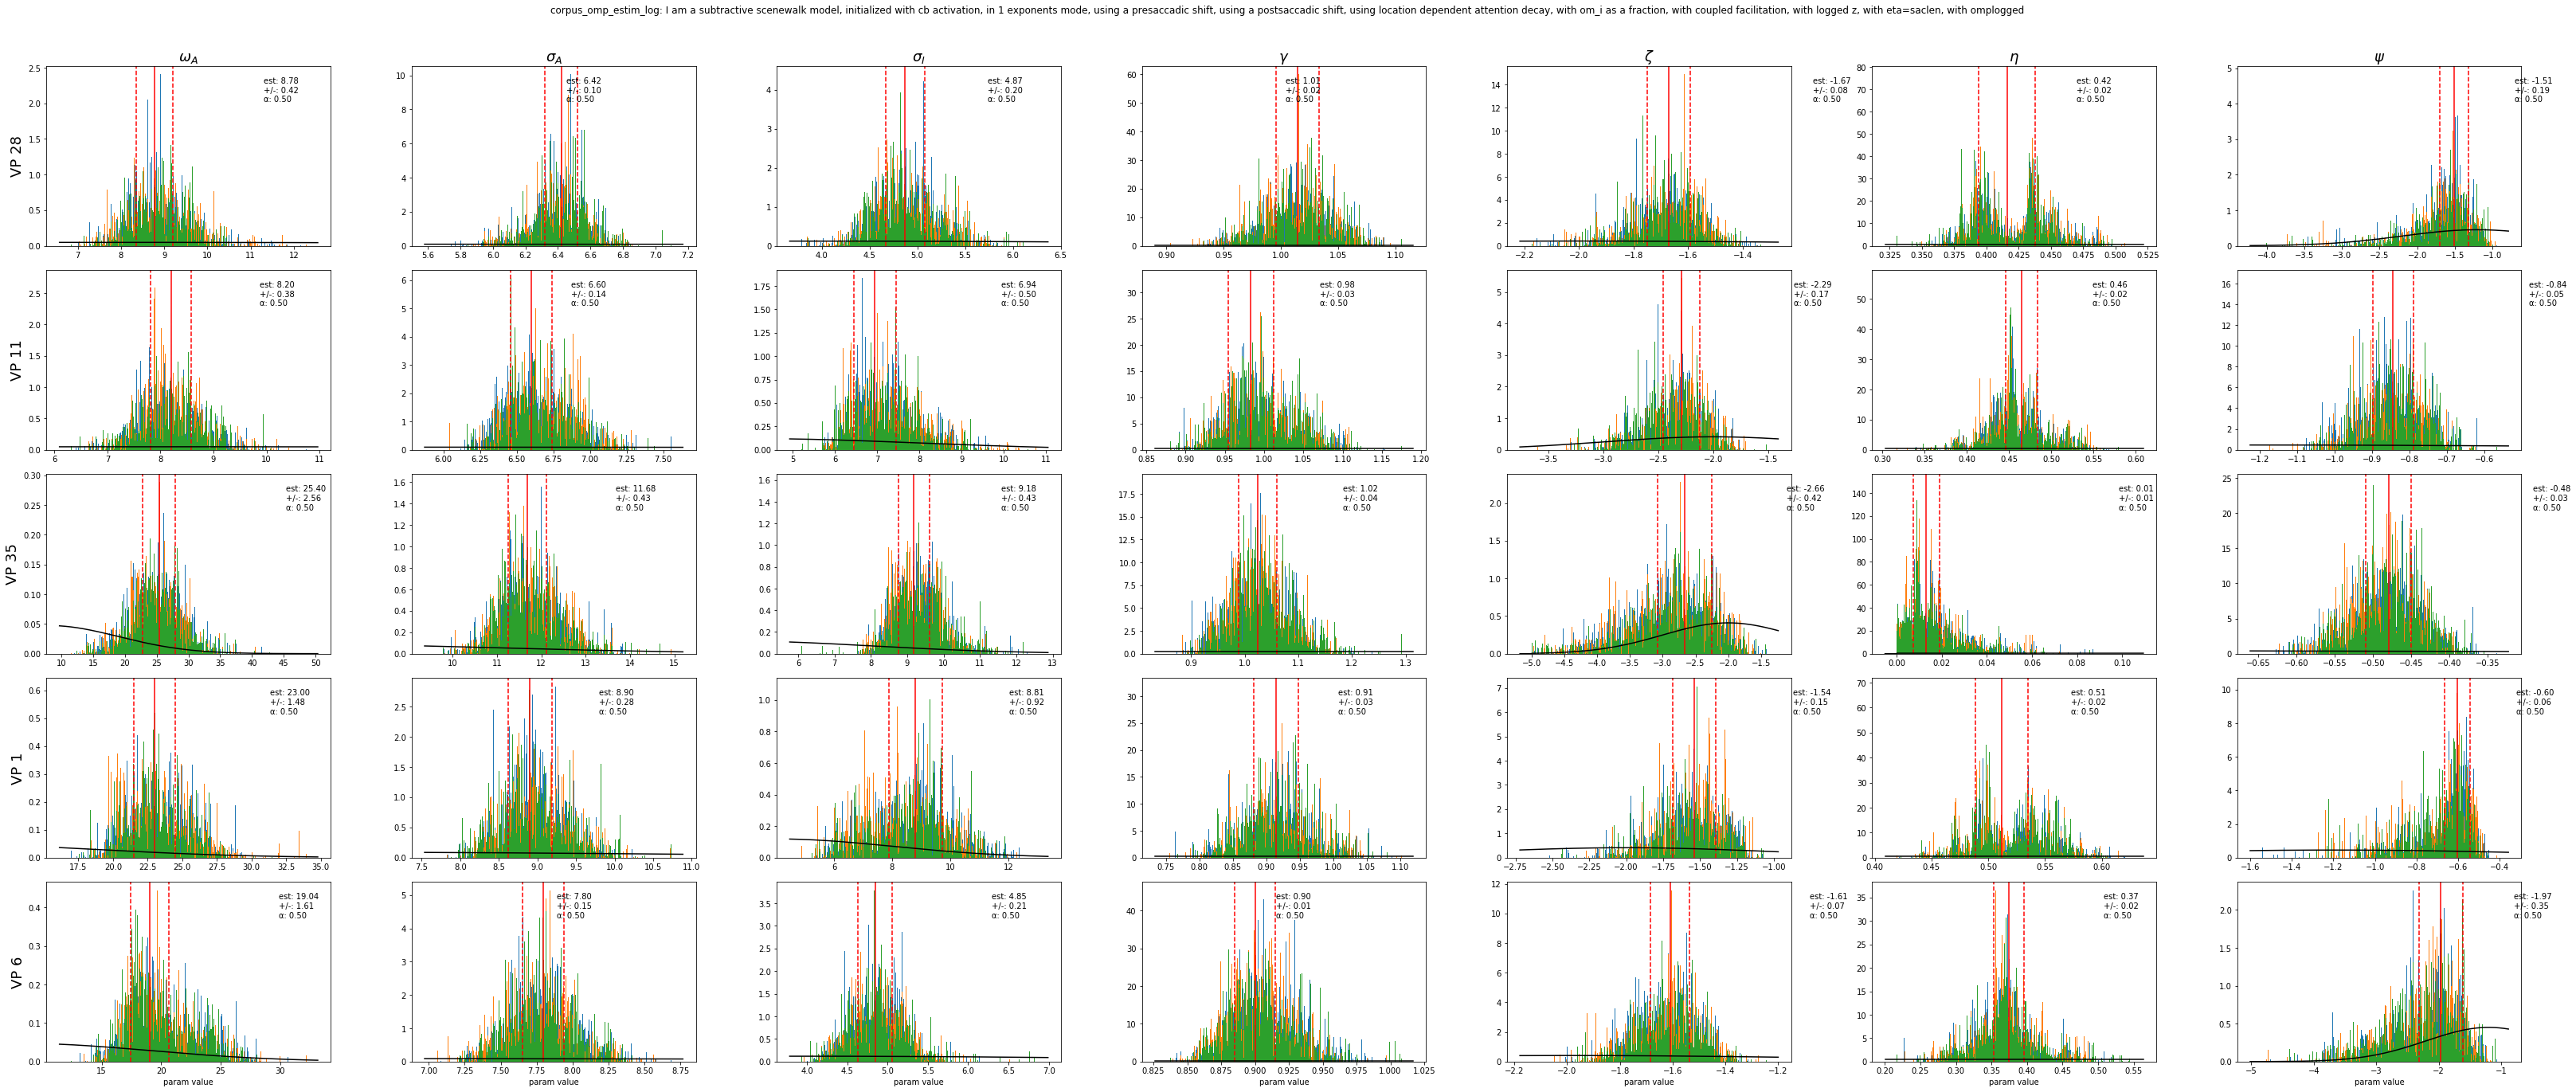

In [40]:
nrow = len(vp_list) #vps
ncol = 7 #params
fig, ax = plt.subplots(nrow, ncol, figsize=(45, 20))
fig.suptitle(TITLE + ": " + sw.whoami())
ax = ax.ravel()

plt_idx = 0
row_idx = 0
for vp in vp_list:
    chains = chains_list[vp]
#for chains in chains_list:
    param_ix = 0
    for param_name in list(priors.keys()):
        # Set up Row and column names
        if row_idx == 0:
            p_name = p_names_formatted[param_name]
            ax[plt_idx].set_title(p_name, fontsize=18)
        if row_idx == nrow-1:
            ax[plt_idx].set_xlabel("param value")
        if param_name == list(priors.keys())[0]:
            ax[plt_idx].set_ylabel("VP "+ str(vp_list[row_idx]+1), fontsize=18)

        # Plot Chains
        chain1 = chains[0,5000:,param_ix]
        chain2 = chains[1,5000:,param_ix]
        chain3 = chains[2,5000:,param_ix]
        
        ax[plt_idx].hist(chain1, bins=600, density=True)
        ax[plt_idx].hist(chain2, bins=600, density=True)
        ax[plt_idx].hist(chain3, bins=600, density=True)        
        
        # Highst Posterior Density
        allchains = np.hstack((chain1, chain2, chain3))
        hpd_all = hpd(allchains, credible_interval)
        mpde = (hpd_all[1]+hpd_all[0])/2
        ax[plt_idx].axvline(x=hpd_all[0], c="red", linestyle="--")
        ax[plt_idx].axvline(x=hpd_all[1], c="red", linestyle="--")
        ax[plt_idx].axvline(x=mpde, c="red", linestyle="-")

        # Text Info About estimate (positioning and printing)
        max_y = ax[plt_idx].get_ylim()[1] - 0.2*ax[plt_idx].get_ylim()[1]
        max_x = ax[plt_idx].get_xlim()[1] - 0.1*ax[plt_idx].get_xlim()[1]
        ax[plt_idx].text(max_x ,max_y ,'est: %.2f\n+/-: %.2f\nα: %.2f' % (mpde, mpde-hpd_all[0], credible_interval ), fontsize = 10)
        
        # prior
        l,r = ax[plt_idx].get_xlim()
        x = np.arange(l, r, (r-l)/1000)
        ax[plt_idx].plot(x, priors[param_name].pdf(x), c='black' )

        plt_idx += 1
        param_ix += 1
    row_idx +=1
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.subplots_adjust(left=0.15, top=0.95)


In [41]:
fig.savefig(estim_id + "estims_hist.png")

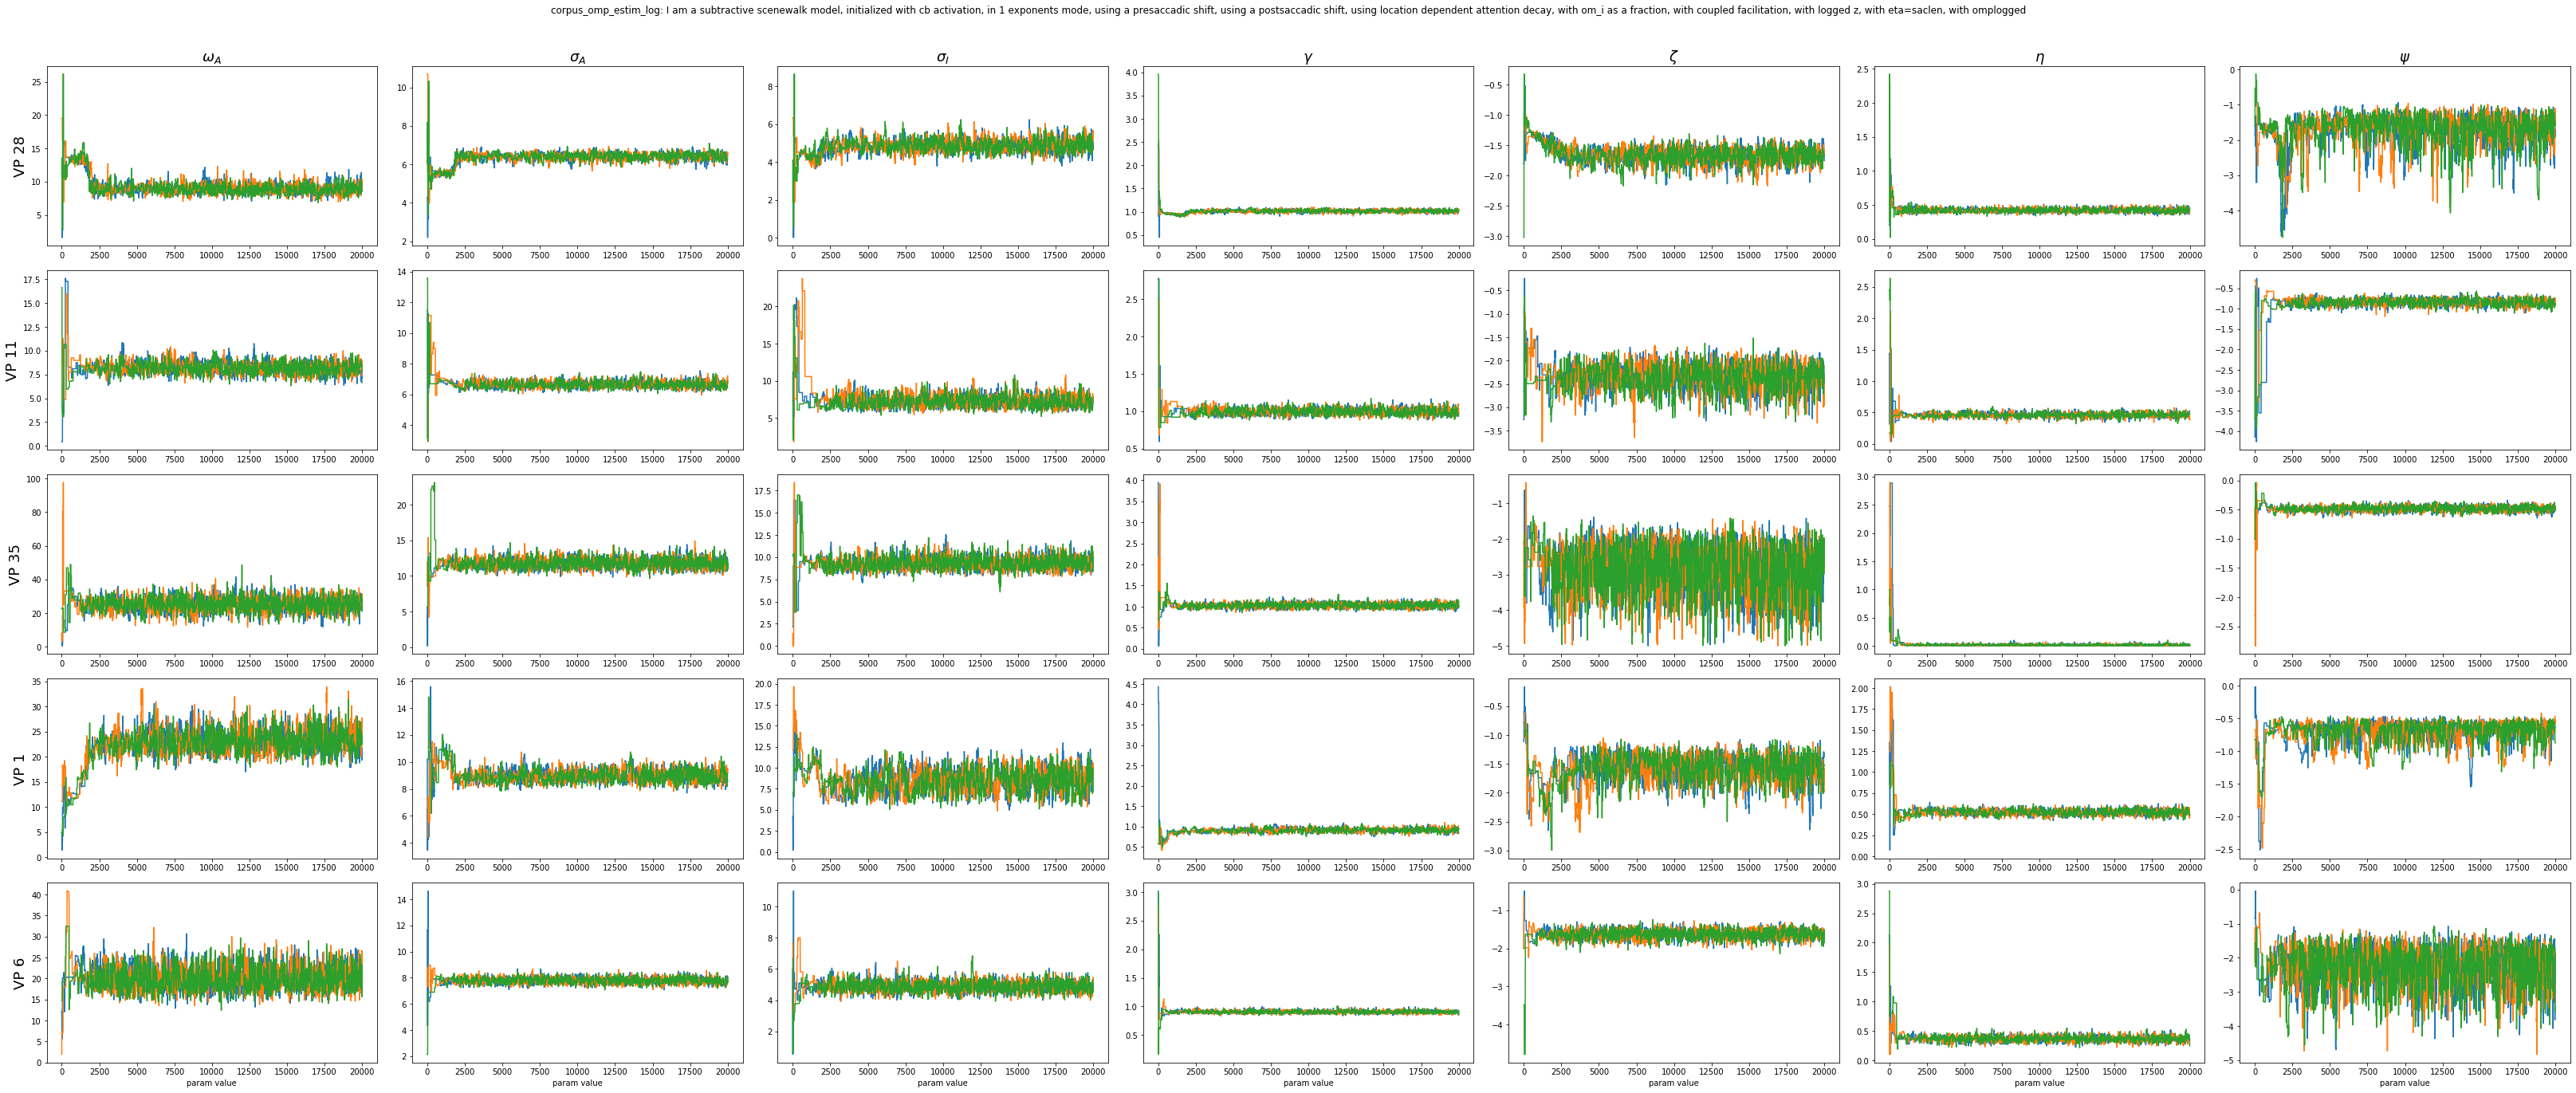

In [42]:
nrow = len(vp_list) #vps
ncol = 7 #params
fig, ax = plt.subplots(nrow, ncol, figsize=(45, 20))
fig.suptitle(TITLE + ": " + sw.whoami())
ax = ax.ravel()

plt_idx = 0
row_idx = 0
for vp in vp_list:
    chains = chains_list[vp]
    param_ix = 0
    for param_name in list(priors.keys()):
        #param_name = list(priors.keys())[param_ix]
        prior_mean = priors[param_name].kwds['loc']
        if row_idx == 0:
            p_name = p_names_formatted[param_name]
            ax[plt_idx].set_title(p_name, fontsize=18)
        if row_idx == nrow-1:
            ax[plt_idx].set_xlabel("param value")
        if param_name == "omegaAttention":
            ax[plt_idx].set_ylabel("VP "+ str(vp_list[row_idx]+1), fontsize=18)
            
        ax[plt_idx].plot(chains[0,:,param_ix])
        ax[plt_idx].plot(chains[1,:,param_ix])
        ax[plt_idx].plot(chains[2,:,param_ix])
        plt_idx += 1
        param_ix += 1
    row_idx +=1
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [43]:
fig.savefig(estim_id + "estims_chains.png")

# Plot VPS over each other

In [31]:
cols = utils.get_all_colors()
random.shuffle(cols)

In [32]:
#utils.show_all_colors()

In [33]:
"whitesmoke","lightcyan", "powderblue", "skyblue", "steelblue", "slategrey", "midnightblue"

('whitesmoke',
 'lightcyan',
 'powderblue',
 'skyblue',
 'steelblue',
 'slategrey',
 'midnightblue')

In [34]:
all_cols = cols
cols = ['teal', "deepskyblue",  "lightskyblue", "cornflowerblue", "mediumslateblue", "darkorchid","indigo",    "slateblue", "steelblue", "mediumblue", "rebeccapurple", "blueviolet"]

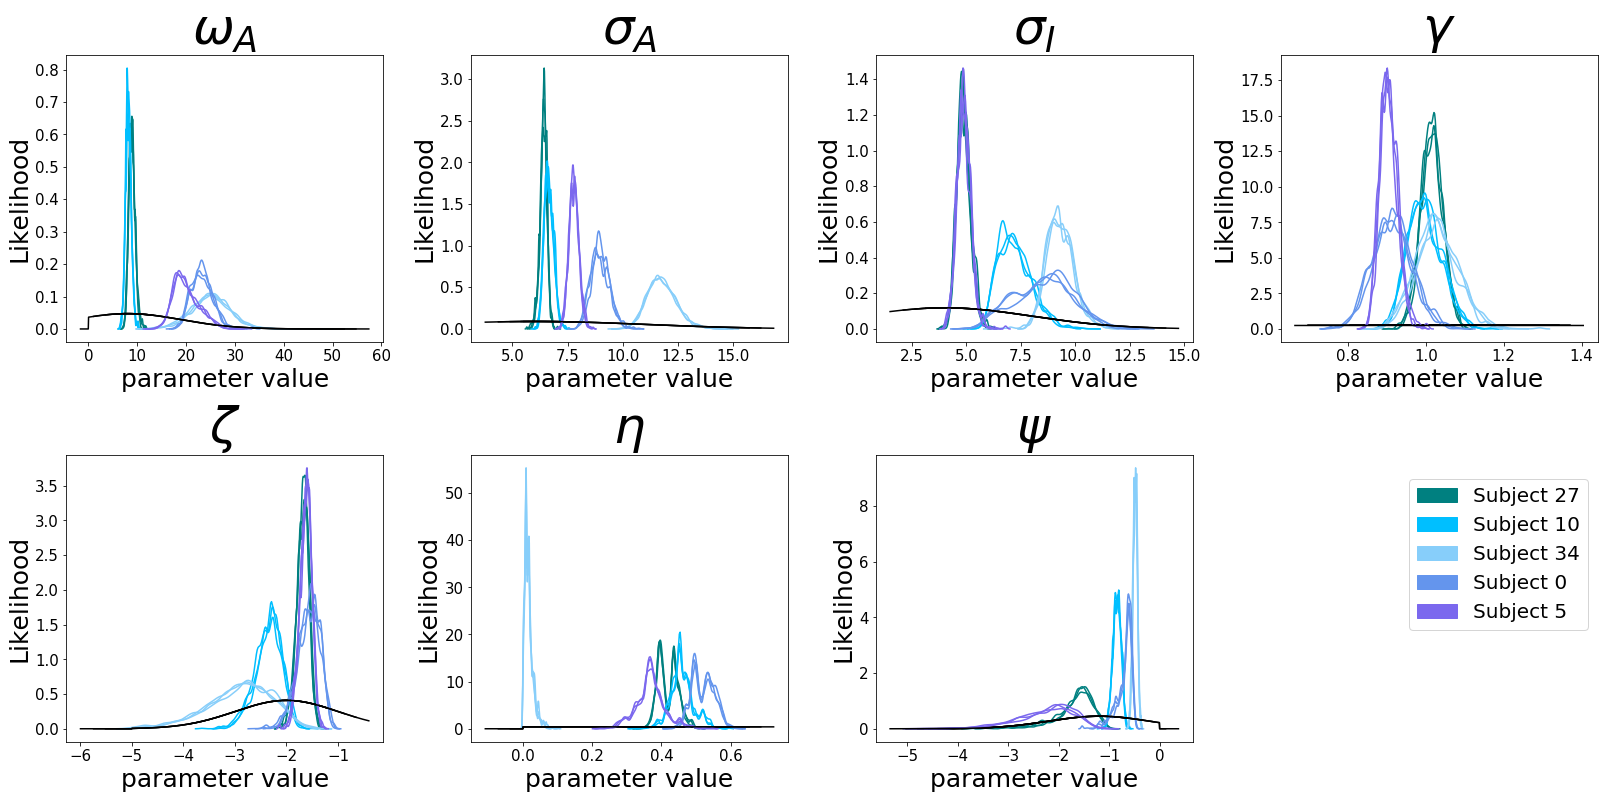

In [38]:
nrow = 2 #vps
ncol = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(25, 14))
ax = ax.ravel()
#alpha = 0.5
pat_list=[]
plt_idx = 0
row_idx = 0
vp_idx = 0
for vp in vp_list:
    chains = chains_list[vp]
    param_ix = 0
    for param_name in list(priors.keys()):
        # Set up Row and column names
        if row_idx == 0:
            p_name = p_names_formatted[param_name]
            ax[plt_idx].set_title(p_name, fontsize=50)
            ax[plt_idx].set_xlabel("parameter value", fontsize=25)
            ax[plt_idx].set_ylabel("Likelihood", fontsize=25)
        ax[plt_idx].tick_params(axis='both', which='major', labelsize=15)
        ax[plt_idx].tick_params(axis='both', which='minor', labelsize=15)
        
        # Plot Chains
        chain1 = chains[0,5000:,param_ix]
        chain2 = chains[1,5000:,param_ix]
        chain3 = chains[2,5000:,param_ix]
         
        sns.distplot(chain1, hist=False, ax=ax[plt_idx], color=cols[vp_idx])
        sns.distplot(chain2, hist=False, ax=ax[plt_idx], color=cols[vp_idx])
        sns.distplot(chain3, hist=False, ax=ax[plt_idx], color=cols[vp_idx])
        
        l,r = ax[plt_idx].get_xlim()
        x = np.arange(l, r, (r-l)/1000)
        ax[plt_idx].plot(x, priors[param_name].pdf(x), c='black' )
        
        #ax[plt_idx].set_facecolor('white')
        
        
        plt_idx += 1
        param_ix += 1
    pat = mpatches.Patch(color=cols[vp_idx], label="Subject "+str(vp))
    pat_list.append(pat)
    plt_idx =0
    vp_idx += 1
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)
fig.tight_layout(rect=[0, 0, 0.9, 0.80])
lll = ax[7].legend(handles=pat_list, bbox_to_anchor=(1,0.95))
#lll.set_fontsize(20)
#lll.handlelength=2
ax[7].set_axis_off()

#frame = lll.get_frame()
#frame.set_color('white')
#frame.set_linewidth(0)

In [39]:
fig.savefig("estims_chains_allinone.png")
fig.savefig("estims_chains_allinone_t.png", transparent=True)

In [51]:
def prange(ext_prior_args, param_name):
    l = ext_prior_args[param_name][2]-(np.sum(ext_prior_args[param_name][2:4])/10)
    r = ext_prior_args[param_name][3]+(np.sum(ext_prior_args[param_name][2:4])/10)
    return(l,r)

TypeError: 'NoneType' object is not subscriptable

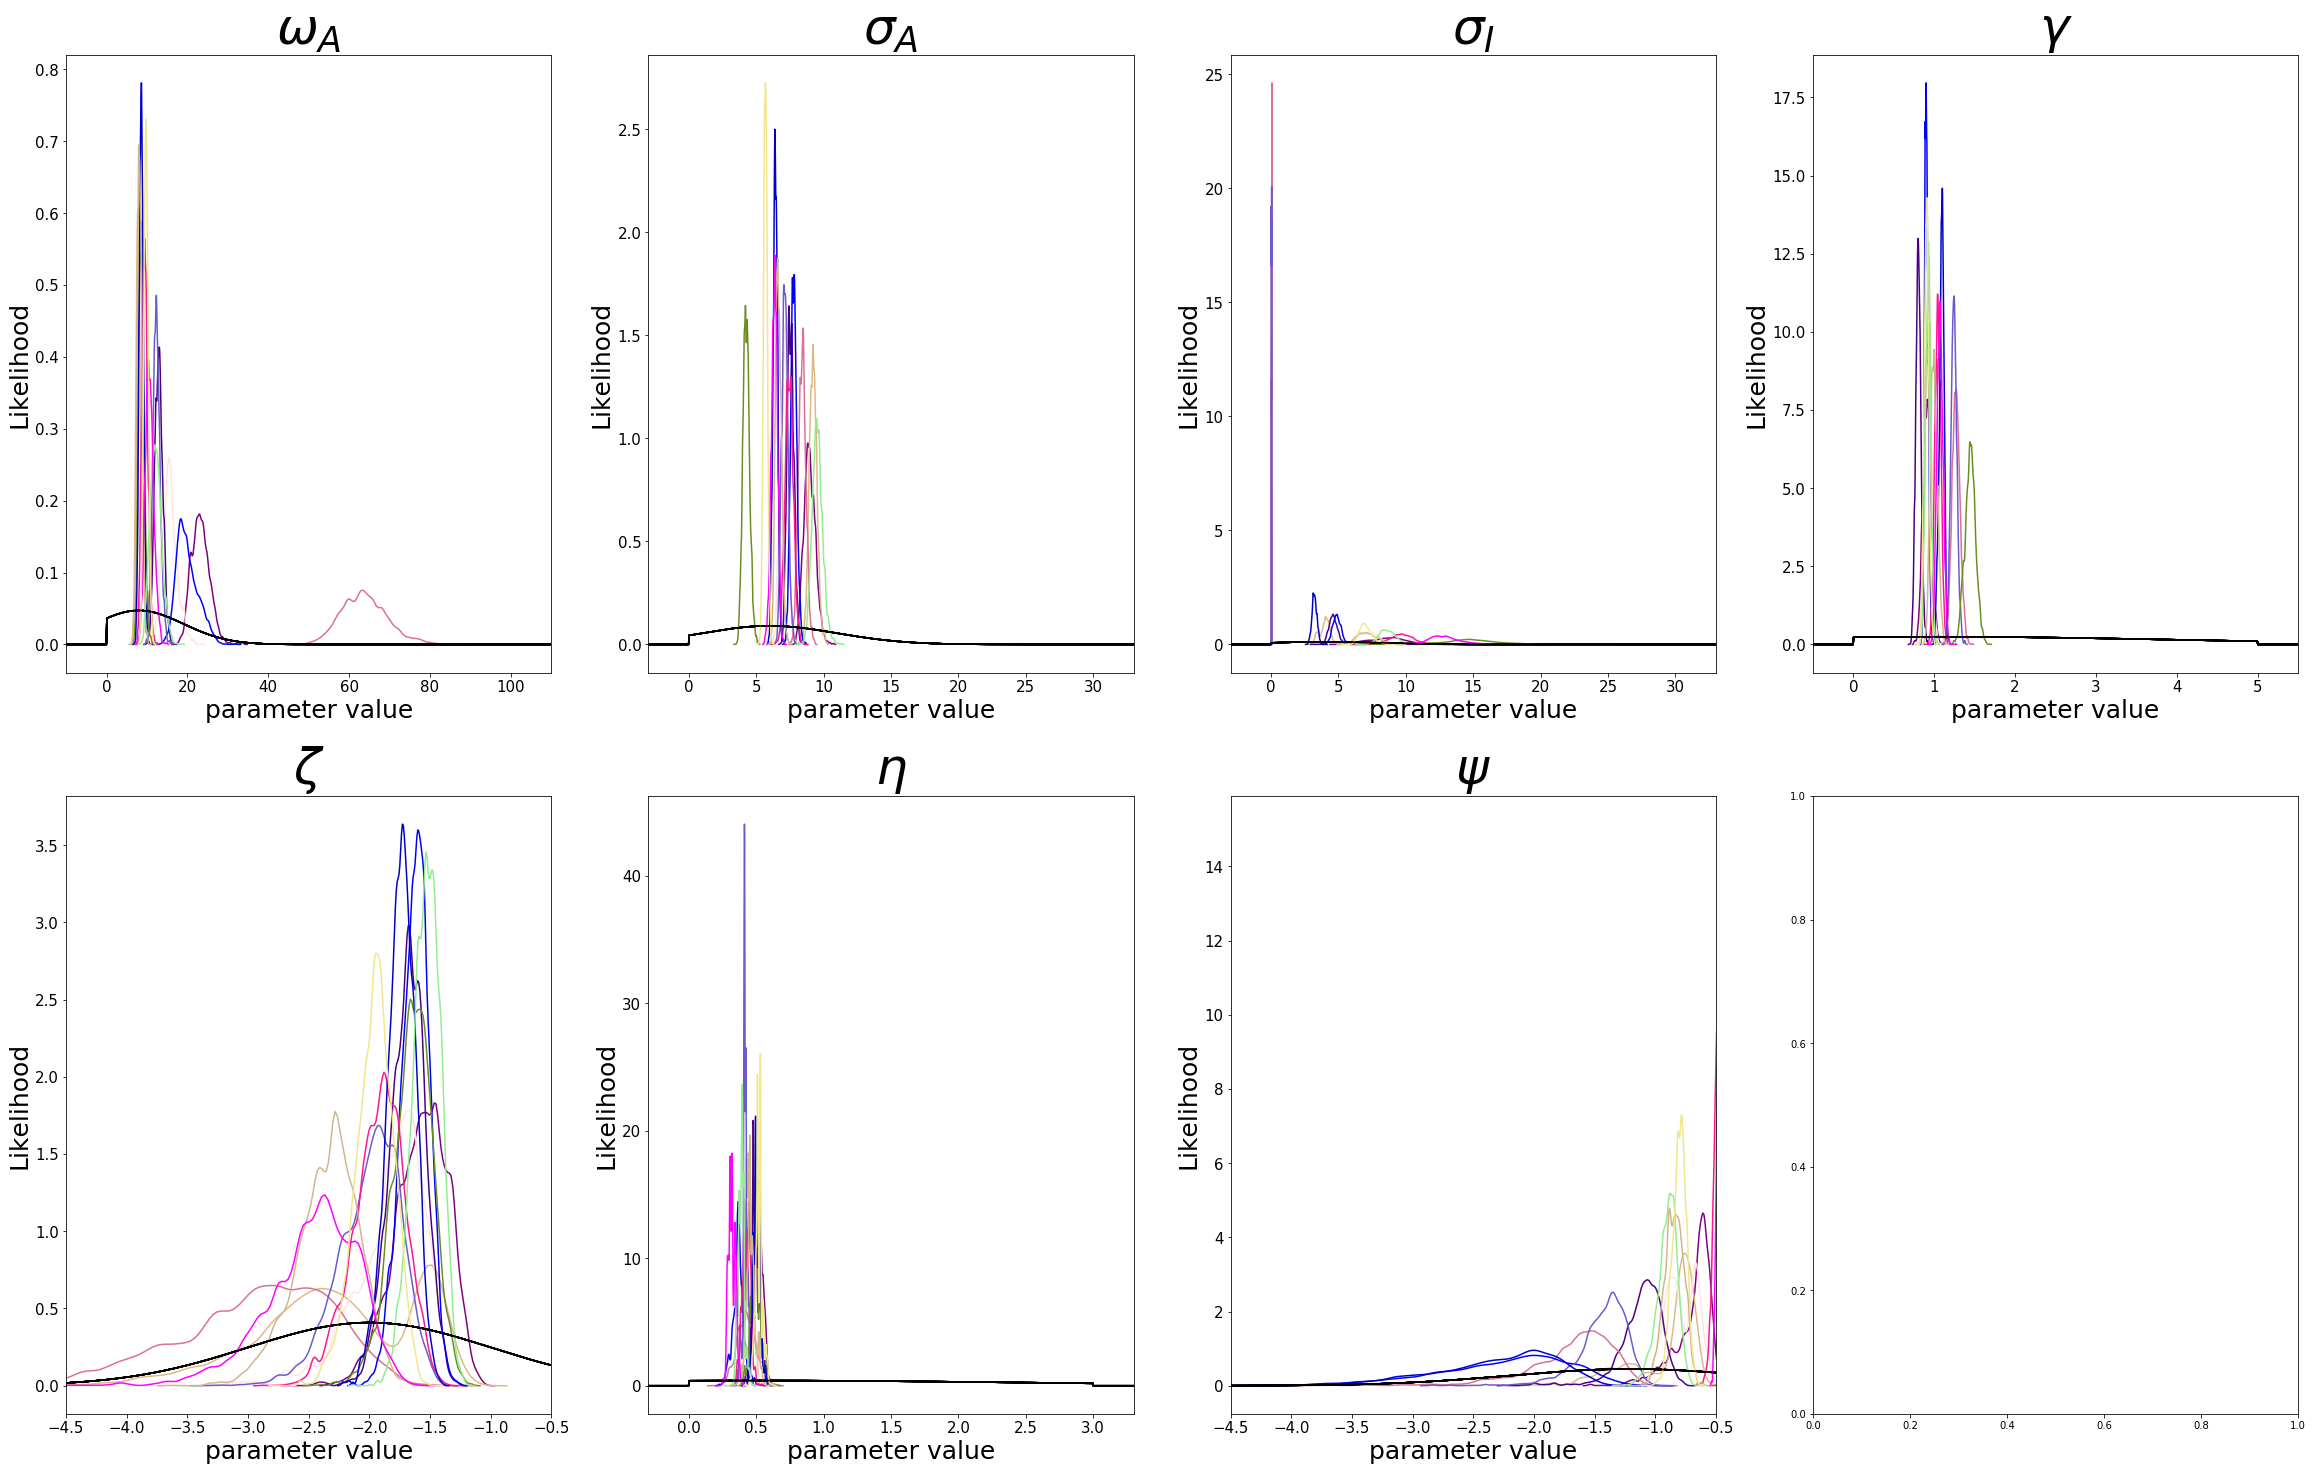

In [52]:
nrow = 2 #vps
ncol = 4
fig, ax = plt.subplots(nrow, ncol, figsize=(40, 25))
ax = ax.ravel()
#alpha = 0.5
pat_list=[]
plt_idx = 0
row_idx = 0
vp_idx = 0
for vp in all_vp_list:
    chains = chains_list[vp]
    param_ix = 0
    for param_name in list(priors.keys()):
        # Set up Row and column names
        if row_idx == 0:
            p_name = p_names_formatted[param_name]
            ax[plt_idx].set_title(p_name, fontsize=50)
            ax[plt_idx].set_xlabel("parameter value", fontsize=25)
            ax[plt_idx].set_ylabel("Likelihood", fontsize=25)
        ax[plt_idx].tick_params(axis='both', which='major', labelsize=15)
        ax[plt_idx].tick_params(axis='both', which='minor', labelsize=15)
        
        # Plot Chains
        chain1 = chains[0,5000:,param_ix]
        chain2 = chains[1,5000:,param_ix]
        chain3 = chains[2,5000:,param_ix]
        chains_all = []
        chains_all = np.concatenate((chain1, chain2, chain3), axis= None )
        sns.distplot(chains_all, hist=False, ax=ax[plt_idx], color=all_cols[vp_idx])
        
        
        l,r = prange(prior_args, param_name)
#        l,r = ax[plt_idx].get_xlim()
        x = np.arange(l, r, (r-l)/1000)
        ax[plt_idx].plot(x, priors[param_name].pdf(x), c='black' )  
        ax[plt_idx].set_xlim(l,r)
        plt_idx += 1
        param_ix += 1
    pat = mpatches.Patch(color=all_cols[vp_idx], label="Subject "+str(vp))
    pat_list.append(pat)
    plt_idx =0
    vp_idx += 1
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)
#ax[7].legend(handles=pat_list, bbox_to_anchor=(1,0.95))
fig.tight_layout(rect=[0, 0, 0.9, 0.80])
#ax[7].set_axis_off()
fig.savefig("estims_chains_allinone_allvp.png")

## Violins

In [53]:
hpde_overall

param_name       mpde    interv      left      right
0             omegaAttention  10.349172  2.622126  7.727046  12.971298
1                     omfrac  10.000000       NaN       NaN        NaN
2             sigmaAttention   7.242574  1.015062  6.227512   8.257637
3                 sigmaInhib   6.707534  2.724186  3.983347   9.431720
4                      gamma   0.965227  0.102286  0.862940   1.067513
5              inhibStrength   0.300000       NaN       NaN        NaN
6                       zeta  -1.784078  0.249037 -2.033115  -1.535041
7                 sigmaShift   2.000000       NaN       NaN        NaN
8                 shift_size   0.454833  0.080632  0.374201   0.535466
9   first_fix_OmegaAttention   1.500000       NaN       NaN        NaN
10                   cb_sd_x   4.000000       NaN       NaN        NaN
11                   cb_sd_y   3.000000       NaN       NaN        NaN
12        omega_prevloc_frac  10.000000       NaN       NaN        NaN
13                       chi   0.100000       NaN       NaN        NaN
14                 ompfactor  -0.615722  0.213925 -0.829647  -0.401797
15                   tau_pre        NaN       NaN       NaN        NaN
16                  tau_post        NaN       NaN       NaN        NaN
17                  foR_size        NaN       NaN       NaN        NaN
18                       chi        NaN       NaN       NaN        NaN
19                       psi        NaN       NaN       NaN        NaN

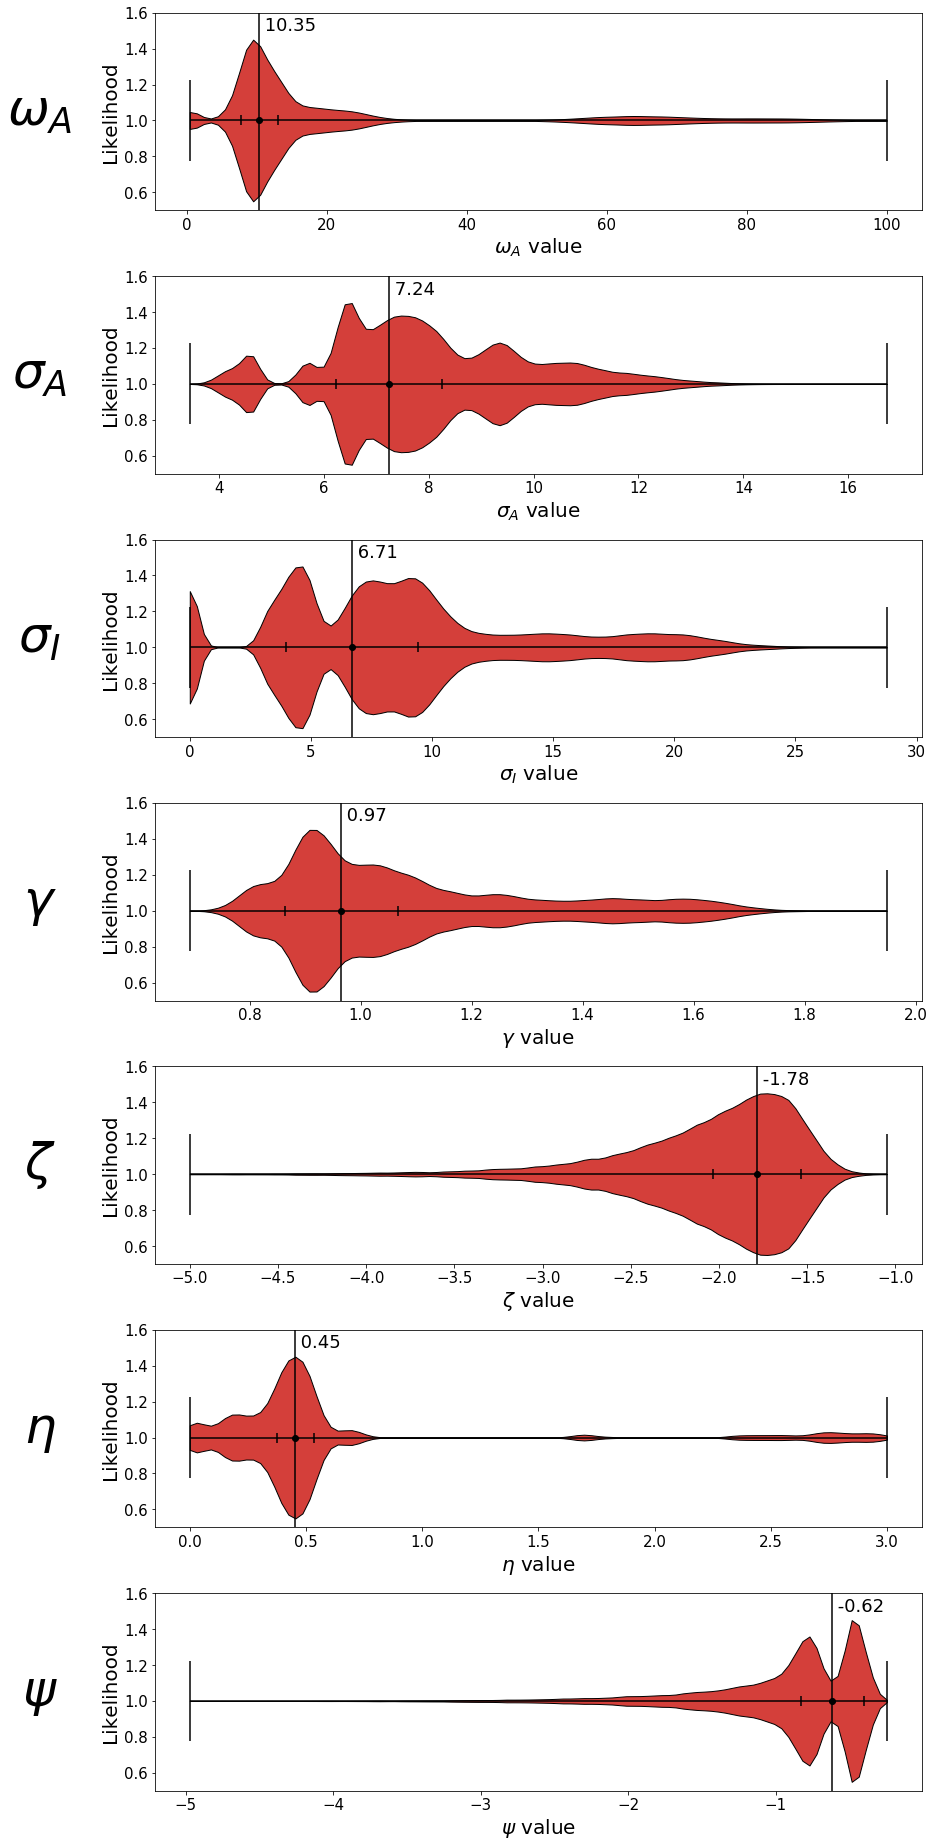

In [54]:
fig, ax = plt.subplots(7,1,figsize=(13, 28))
param_ix = 0
plt_idx = 0
vp_idx = 0
ax = ax.ravel()
for param_name in list(priors.keys()):
    param_chains = []
    for vp in all_vp_list:
        chains = chains_list[vp]
        if chains is None:
            continue
        chain1 = chains[0,5000:,param_ix]
        chain2 = chains[1,5000:,param_ix]
        chain3 = chains[2,5000:,param_ix]
        chains_all = np.concatenate((chain1, chain2, chain3), axis= None )
        param_chains.extend(chains_all)
    param_ix += 1     
    parts = ax[plt_idx].violinplot(param_chains, vert=False, widths=0.9)# positions = vp_list
    # extract info from dataframe
    mean_mpde = hpde_overall[hpde_overall["param_name"]==param_name]["mpde"].values.item()
    left = hpde_overall[hpde_overall["param_name"]==param_name]["left"].values.item()
    right = hpde_overall[hpde_overall["param_name"]==param_name]["right"].values.item()
    #print(mean_mpde)
    ax[plt_idx].axvline(x=mean_mpde, c="black")
    ax[plt_idx].annotate(" {:.2f}".format(mean_mpde),
                xy=(mean_mpde, 1.5), xycoords="data", fontsize=18) #ax[plt_idx].transAxes
    ax[plt_idx].scatter(mean_mpde, 1, c="black")
    ax[plt_idx].scatter(left,1 , marker="|", s=100, c="black")
    ax[plt_idx].scatter(right, 1, marker="|", s=100, c="black")    
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
#    for pc in parts['cbars']:
    parts['cbars'].set_edgecolor('black')
    parts['cmins'].set_edgecolor('black')
    parts['cmaxes'].set_edgecolor('black')

    ax[plt_idx].set_ylim(0.5, 1.6)
    ax[plt_idx].set_xlabel(p_names_formatted[param_name]+" value", fontsize=20)
    ax[plt_idx].set_ylabel("Likelihood", fontsize=20)
    ax[plt_idx].set_title(p_names_formatted[param_name], fontsize=50,x=-0.15,y=0.4)
    ax[plt_idx].tick_params(axis='both', which='major', labelsize=15)
    ax[plt_idx].tick_params(axis='both', which='minor', labelsize=15)
    
    #ax[plt_idx].text(0, 0.5, "test")
    plt_idx += 1

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("estim_violins_overall.png")

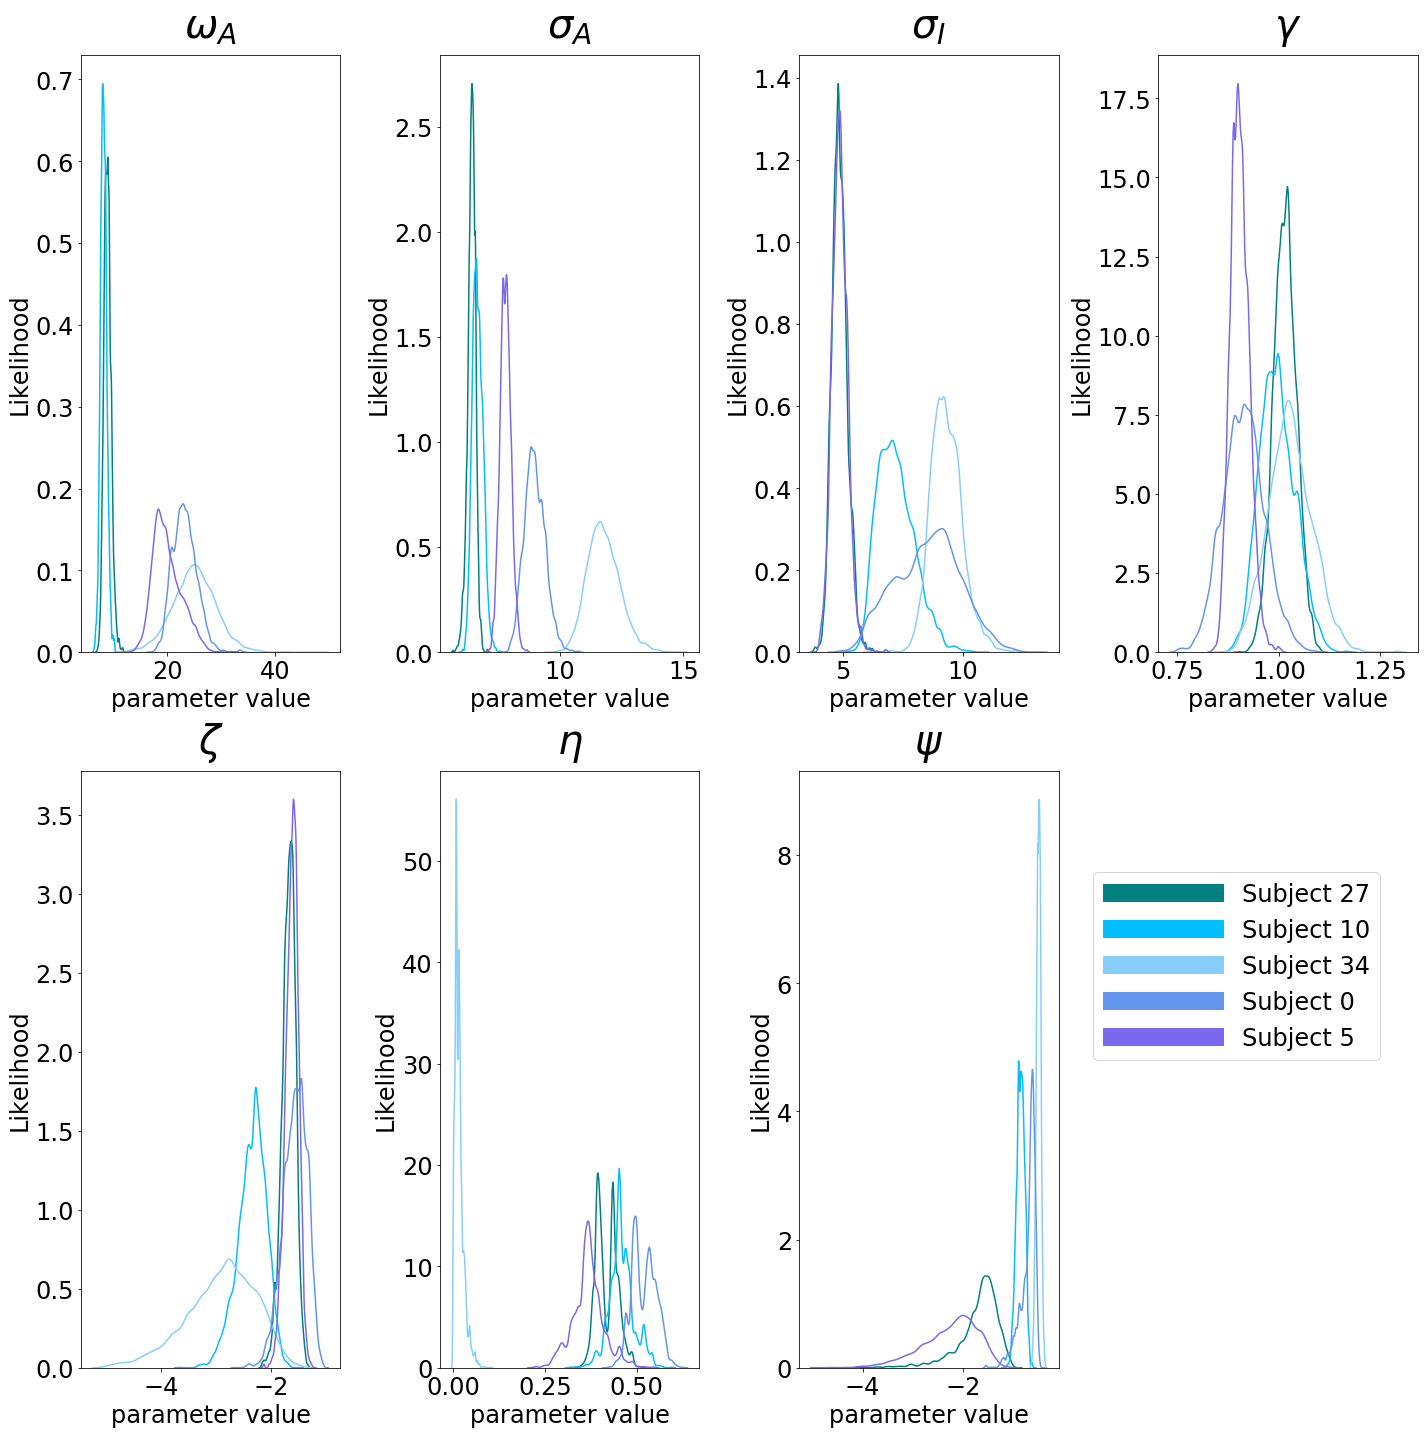

In [55]:
pat_list=[]
nrow = 2 #vps
ncol = 4 #params
fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
ax = ax.ravel()
#alpha = 0.5

plt_idx = 0
row_idx = 0
vp_idx = 0
for vp in vp_list:
    chains = chains_list[vp]
    param_ix = 0
    for param_name in list(priors.keys()):
        p_name = p_names_formatted[param_name]
        ax[plt_idx].set_title(p_name, fontsize=40, y=1.02)
        ax[plt_idx].set_xlabel("parameter value", fontsize=24)
        ax[plt_idx].set_ylabel("Likelihood", fontsize=24)
        ax[plt_idx].tick_params(axis='both', which='major', labelsize=24)
        ax[plt_idx].tick_params(axis='both', which='minor', labelsize=24)

        # Plot Chains
        chain1 = chains[0,5000:,param_ix]
        chain1 = np.append(chain1, chains[1,5000:,param_ix])
        chain1 = np.append(chain1, chains[2,5000:,param_ix])
        
        sns.distplot(chain1, hist=False, ax=ax[plt_idx], color=cols[vp_idx])

        l,r = ax[plt_idx].get_xlim()
        x = np.arange(l, r, (r-l)/1000)
        #ax[plt_idx].plot(x, priors[param_name].pdf(x), c='black' )
        
        plt_idx += 1
        param_ix += 1
    pat = mpatches.Patch(color=cols[vp_idx], label="Subject "+str(vp))
    pat_list.append(pat)
    plt_idx = 0
    vp_idx += 1
    
fig.tight_layout()

params = {'legend.fontsize': 24,
          'legend.handlelength': 5}
plt.rcParams.update(params)
plt.legend(handles=pat_list, bbox_to_anchor=(0.9,0.85))
#ax[6].set_axis_off()
ax[7].set_axis_off()
#ax[8].set_axis_off()
#ax[1].set_xlim(-3,103)
#ax[2].set_xlim(-2,33)
#ax[3].set_xlim(-2,33)
#ax[4].set_xlim(-0.2,3)
#ax[5].set_xlim(-0.1,0.6)
#ax[6].set_xlim(-2,33)
#ax[7].set_xlim(-2,12)

In [56]:
fig.savefig("estims_chains_allinone.png")

# VP Parameter differences
Here we create a pandas dataframe that includes point estimates and confidence intervals for each subject and parameter

In [66]:
sw.update_params([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
sw.get_params()

OrderedDict([('omegaAttention', 1),
             ('omegaInhib', 1.0),
             ('sigmaAttention', 1),
             ('sigmaInhib', 1),
             ('gamma', 1),
             ('inhibStrength', 1),
             ('zeta', 10),
             ('sigmaShift', 1),
             ('shift_size', 1),
             ('first_fix_OmegaAttention', 1),
             ('cb_sd_x', 1),
             ('cb_sd_y', 1),
             ('omega_prevloc', 1.0),
             ('chi', 1),
             ('ompfactor', 10)])

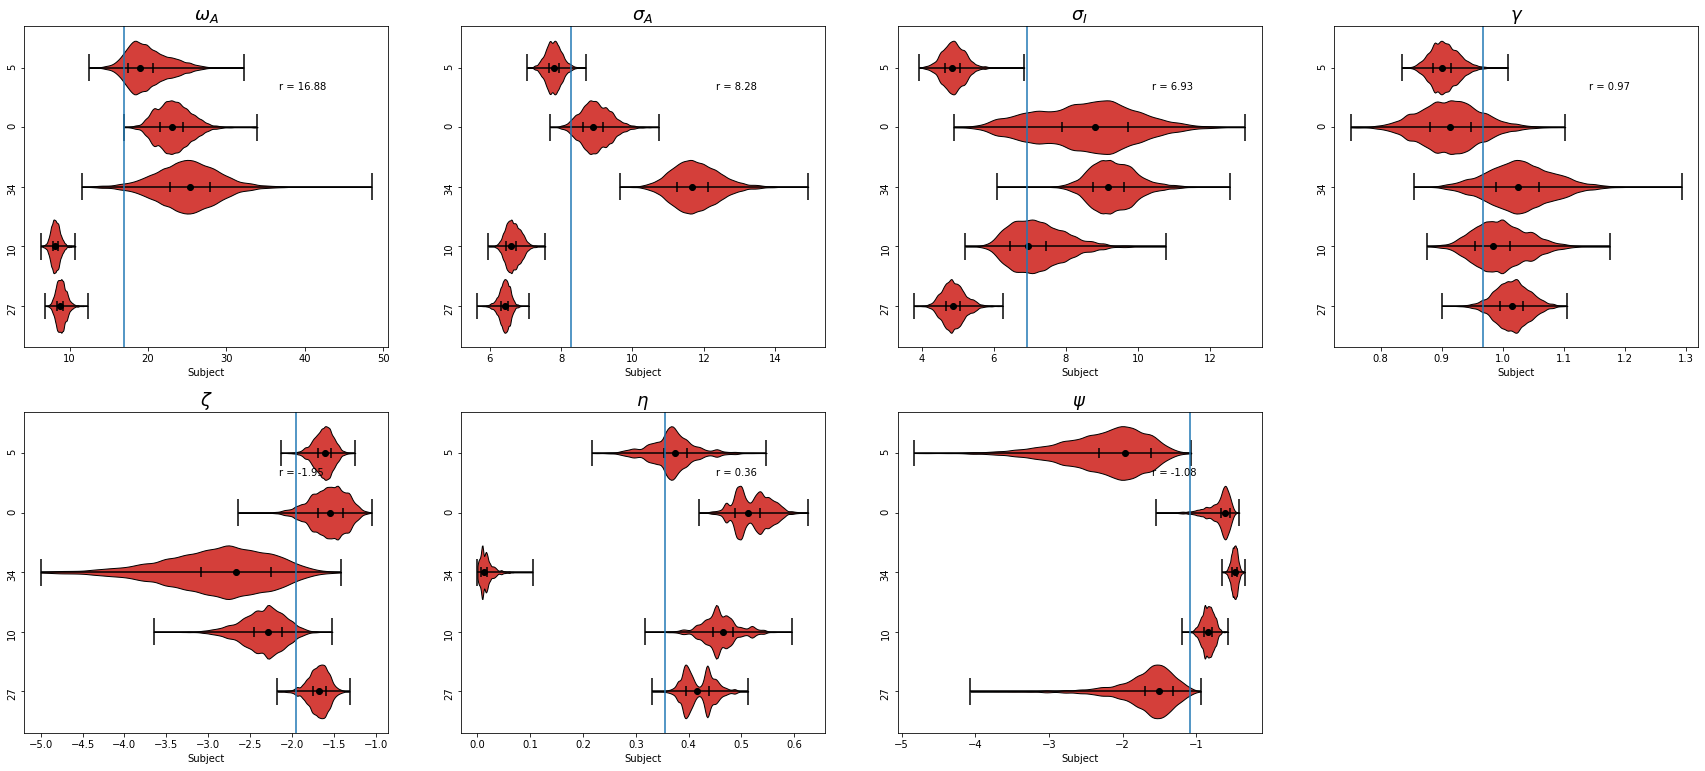

In [57]:
hpde_df_short = hpde_subj[hpde_subj["vp"].isin(vp_list)]
vp_strs = [str(v) for v in vp_list]
vp_idx_dict = OrderedDict((v, i) for i, v in list(zip(range(len(vp_list)),vp_list)))


nrow = 2 #rows
ncol = 4 #cols
fig, ax = plt.subplots(nrow, ncol, figsize=(30, 13))
ax = ax.ravel()
param_ix = 0
plt_idx = 0
vp_idx = 0
for param_name in list(priors.keys()):
    param_chains = []
    for vp in vp_list:
        chains = chains_list[vp]
        chain1 = chains[0,5000:,param_ix]
        chain2 = chains[1,5000:,param_ix]
        chain3 = chains[2,5000:,param_ix]
        chains_all = np.concatenate((chain1, chain2, chain3), axis= None )
        param_chains.append(chains_all)
        
    parts = ax[plt_idx].violinplot(param_chains, vert=False, widths=0.9)# positions = vp_list
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
#    for pc in parts['cbars']:
    parts['cbars'].set_edgecolor('black')
    parts['cmins'].set_edgecolor('black')
    parts['cmaxes'].set_edgecolor('black')

    param_frame = hpde_df_short[hpde_df_short["param_name"]==param_name]
    vp_idx_list = [vp_idx_dict[i]+1 for i in param_frame["vp"]]
    mean_mpde = np.mean(param_frame["mpde"])
    ax[plt_idx].axvline(x=mean_mpde)
    ax[plt_idx].annotate("r = {:.2f}".format(mean_mpde),
                xy=(.7, .8), xycoords=ax[plt_idx].transAxes)
    ax[plt_idx].scatter(param_frame["mpde"],vp_idx_list, c="black")
    ax[plt_idx].scatter(param_frame["left"],vp_idx_list, marker="|", s=100, c="black")
    ax[plt_idx].scatter(param_frame["right"],vp_idx_list, marker="|", s=100, c="black")
    ax[plt_idx].set_xlabel("param value")
    ax[plt_idx].set_xlabel("Subject")
    p_name = p_names_formatted[param_name]
    ax[plt_idx].set_title(p_name, fontsize=18)

    ax[plt_idx].set_yticks(list(range(1, len(vp_list)+1)))
    ax[plt_idx].set_yticklabels(vp_list, rotation=90)
    #print(ax[plt_idx].get_yticks())
    param_ix += 1
    plt_idx += 1
ax[7].set_axis_off()

In [58]:
fig.savefig(estim_id + "violins.png")

In [59]:
param_name = "sigmaAttention"
param_frame = hpde_df_short[hpde_df_short["param_name"]==param_name]

In [60]:
hpde_subj

vp      param_name       mpde    interv       left      right
0     0  omegaAttention  23.004939  1.481143  21.523796  24.486082
1     0  sigmaAttention   8.903240  0.282652   8.620588   9.185892
2     0      sigmaInhib   8.808745  0.916477   7.892268   9.725222
3     0           gamma   0.914263  0.033254   0.881009   0.947516
4     0            zeta  -1.538756  0.147530  -1.686286  -1.391225
..   ..             ...        ...       ...        ...        ...
191  34      sigmaInhib   9.178464  0.427547   8.750918   9.606011
192  34           gamma   1.024391  0.035374   0.989017   1.059765
193  34            zeta  -2.664636  0.416633  -3.081269  -2.248003
194  34      shift_size   0.013147  0.005888   0.007259   0.019035
195  34       ompfactor  -0.479544  0.029373  -0.508917  -0.450171

[196 rows x 6 columns]

# Correlations

Here we plot the autocorrelation function of each parameter. We wantto find out how much we will need to trim the posteriors to get uncorrelated samples. After 100 samples the autocorrelation is pretty much 0

/Users/lisa/Documents/virtual_envs/scenewalk/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


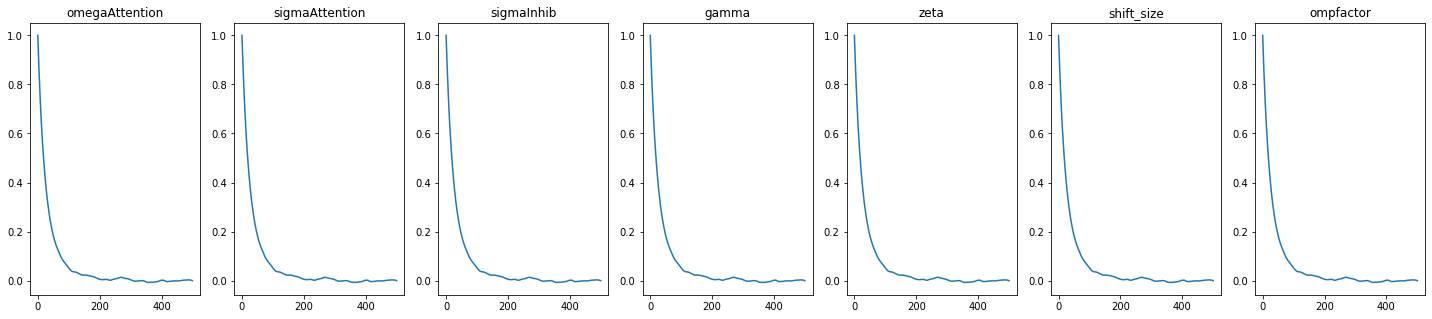

In [61]:
from statsmodels.tsa.stattools import acf, pacf

nrow = 1#rows
ncol = 7 #cols
fig, ax = plt.subplots(nrow, ncol, figsize=(25, 5))
ax = ax.ravel()
param_ix = 0
plt_idx = 0
for param_name in list(priors.keys()):
    autocorrs = []
    for chains in chains_list:
        if chains is None:
            continue
        for c in range(3):
            chain1 = chains[c,5000:,param_ix]
            t_list = acf(chain1, nlags=500)
        autocorrs.append(t_list)
    mean_ac = [np.mean(elts) for elts in zip(*autocorrs)]
    ax[plt_idx].plot(mean_ac)
    ax[plt_idx].set_title(param_name)
    plt_idx+=1

In [62]:
import pandas as pd

trimmed_chains = pd.DataFrame()
acf_limit = 150
vp_id = 0
for vp in vp_list:
    chains = chains_list[vp]
    tmp_df = pd.DataFrame()
    param_ix = 0
    for param_name in list(priors.keys()):
        # Plot Chains
        chain1 = chains[0,5000::acf_limit,param_ix]
        chain2 = chains[1,5000::acf_limit,param_ix]
        chain3 = chains[2,5000::acf_limit,param_ix]
        chains_all = []
        chains_all = np.concatenate((chain1, chain2, chain3), axis= None )
        tmp_df[param_name] = chains_all
        param_ix += 1
    tmp_df['vp'] = vp_id
    vp_id +=1
    trimmed_chains = pd.concat([trimmed_chains, tmp_df])

## Correlation Plot

In [63]:
trimmed_chains

omegaAttention  sigmaAttention  sigmaInhib     gamma      zeta  \
0          9.158233        6.365333    5.057932  1.031376 -1.503435   
1          7.951532        6.528176    4.638055  1.036929 -1.631263   
2          9.339928        6.173010    4.650629  1.006434 -1.484866   
3          9.580334        6.381463    5.227572  1.025248 -1.962503   
4          8.388159        6.228538    4.401884  0.987455 -1.664921   
..              ...             ...         ...       ...       ...   
295       18.453733        7.832852    4.714548  0.894341 -1.726878   
296       19.319897        8.048192    4.925031  0.907883 -1.601887   
297       24.564648        7.400222    4.515498  0.911979 -1.607290   
298       17.178358        7.768983    4.830815  0.888174 -1.637998   
299       23.290170        7.289673    4.548551  0.882589 -1.689252   

     shift_size  ompfactor  vp  
0      0.435147  -1.245872   0  
1      0.430728  -1.736418   0  
2      0.422684  -1.436741   0  
3      0.435216  -1.200346   0  
4      0.447209  -1.388953   0  
..          ...        ...  ..  
295    0.319700  -2.824950   4  
296    0.350057  -2.312458   4  
297    0.329786  -2.303122   4  
298    0.477414  -2.753688   4  
299    0.386127  -2.757773   4  

[1500 rows x 8 columns]

In [64]:
cols = ["white", "whitesmoke","lightcyan", "powderblue","steelblue", "skyblue", "slategrey", "midnightblue", "black"]

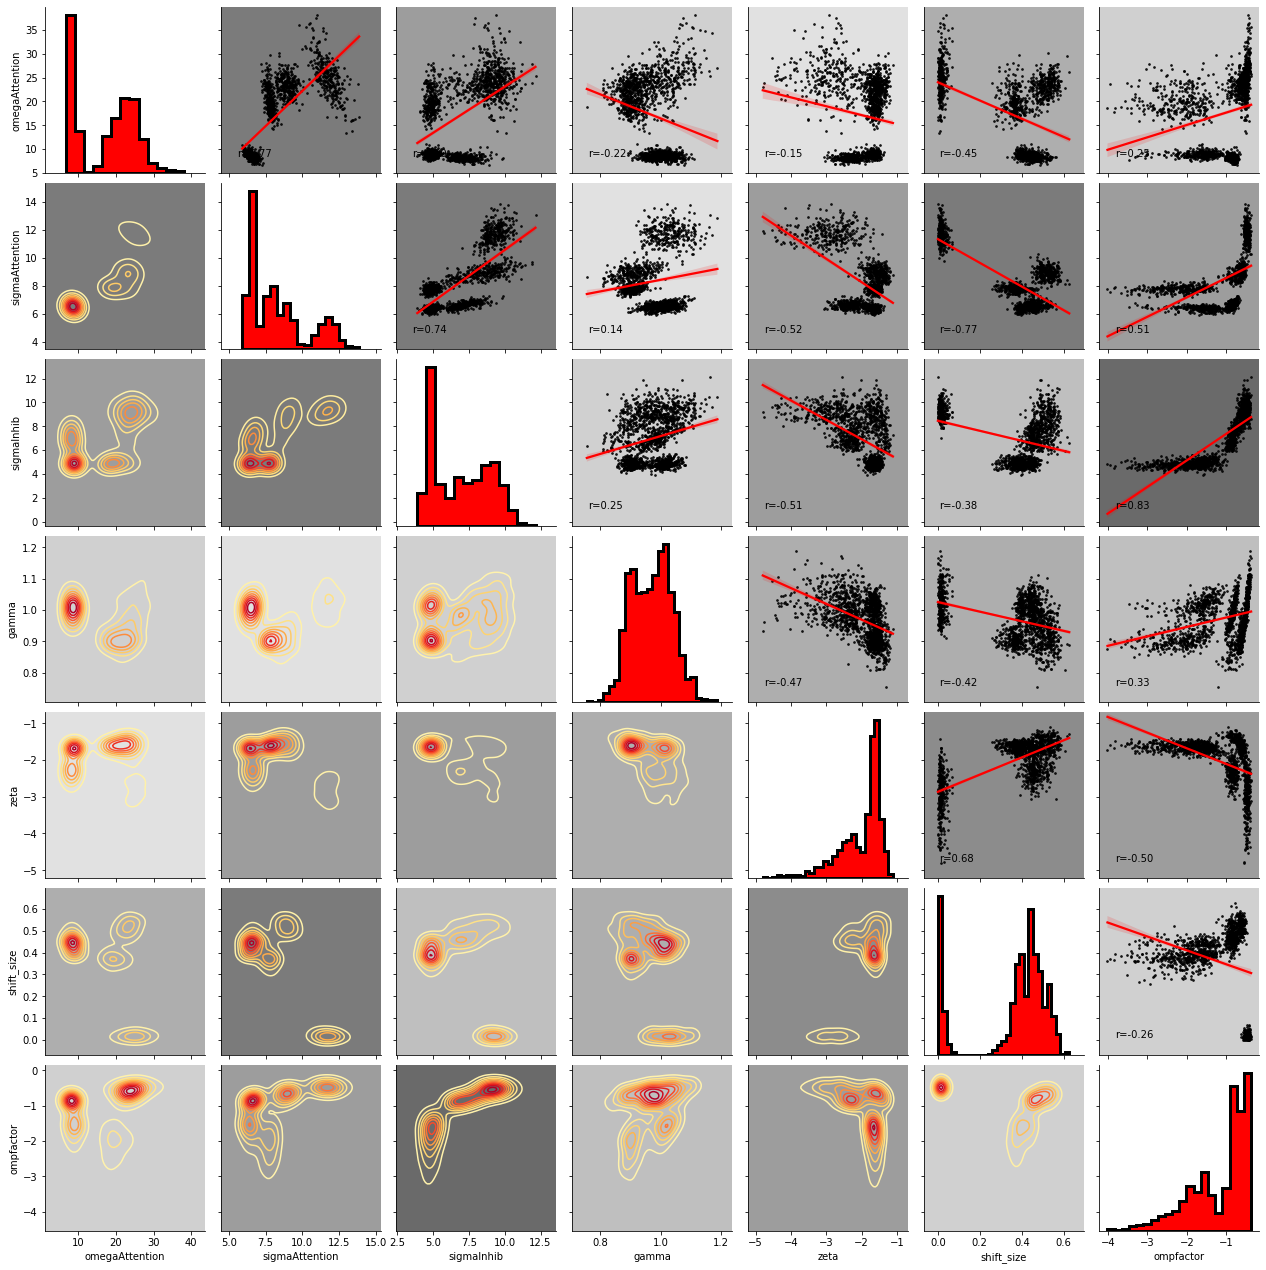

In [80]:
#utils.show_all_colors()
cols = [(i,i,i) for i in np.linspace(0.95,0.35,10)]
param_name_list = list(priors.keys())
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    ax = plt.gca()
    #ax.annotate("r = {:.2f} \np = {:.3f}".format(r,p),
    #            xy=(.1, .1), xycoords=ax.transAxes)
    ax.annotate("r={:.2f}".format(r),
                xy=(.1, .1), xycoords=ax.transAxes)


def make_bg_cols(x,y, **kws):
    r, p = stats.pearsonr(x, y)
    n = int(np.floor(abs(r)*10))
    #print(n, cols[n])
    ax = plt.gca()
    ax.set_facecolor(cols[n])
#def scatter_func(x, y, **kws):
#    ax = plt.gca()
#    ax.scatter(x, y, color="green")
g = sns.PairGrid(trimmed_chains, vars=param_name_list, diag_sharey=False)
#g.map_upper(scatter_func)
g.map_upper(sns.regplot, scatter_kws={'s':3, 'marker': "+", 'color':"black"},line_kws={'color': 'red'})
#g.map_upper(scatter_func)
g.map_diag(sns.distplot, kde=False, hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "red", "edgecolor":'black'})
g.map_lower(sns.kdeplot, cmap="YlOrRd")
g.map_upper(corrfunc)
g.map_upper(make_bg_cols)
g.map_lower(make_bg_cols)

#g.set(ylim=(0, None))

In [81]:
#for i in range(7):
#    for j in range(7):
#        xl = g.axes[i][j].get_xlim()
#        g.axes[i][j].set_ylim(xl)

In [82]:
for i in range(7):
    for j in range(7):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in p_names_formatted.keys():
            g.axes[i][j].set_xlabel(p_names_formatted[xlabel], fontsize=30)
        if ylabel in p_names_formatted.keys():
            g.axes[i][j].set_ylabel(p_names_formatted[ylabel], fontsize=30)

In [83]:
g.savefig(estim_id + "corr.png")

## Simple correlation Matrix Heat Map

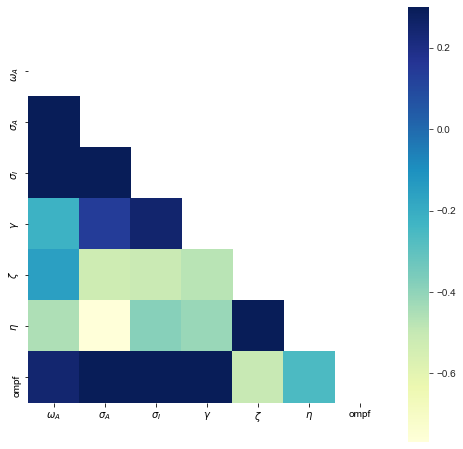

In [78]:
param_name_list_format = [p_names_formatted[p] for p in param_name_list]


trimmed_chains2 = trimmed_chains.drop(columns=['vp'])
trimmed_chains2 = trimmed_chains2.transpose()
corr = np.corrcoef(trimmed_chains2)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 8))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,  cmap="YlGnBu", xticklabels=param_name_list_format, yticklabels=param_name_list_format)
    plt.show()

In [79]:
fig.savefig("corrmat.png")

In [80]:
corr

array([[ 1.        ,  0.7687338 ,  0.50256   , -0.21912664, -0.15185063,
        -0.45169961,  0.24944576],
       [ 0.7687338 ,  1.        ,  0.73618896,  0.13790824, -0.52225918,
        -0.76807332,  0.51173113],
       [ 0.50256   ,  0.73618896,  1.        ,  0.25034537, -0.51098835,
        -0.38357942,  0.82517826],
       [-0.21912664,  0.13790824,  0.25034537,  1.        , -0.47339691,
        -0.41717575,  0.33294091],
       [-0.15185063, -0.52225918, -0.51098835, -0.47339691,  1.        ,
         0.67739291, -0.50156634],
       [-0.45169961, -0.76807332, -0.38357942, -0.41717575,  0.67739291,
         1.        , -0.25900688],
       [ 0.24944576,  0.51173113,  0.82517826,  0.33294091, -0.50156634,
        -0.25900688,  1.        ]])

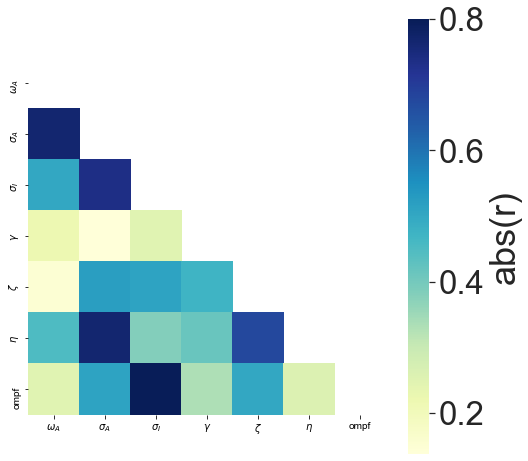

In [81]:
param_name_list_format = [p_names_formatted[p] for p in param_name_list]


trimmed_chains2 = trimmed_chains.drop(columns=['vp'])
trimmed_chains2 = trimmed_chains2.transpose()
corr = np.corrcoef(trimmed_chains2)
corr = np.abs(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 8))
sns.axes_style("white")
sns.set(font_scale=3)
ax = sns.heatmap(corr, mask=mask, square=True, vmax=.8, cmap="YlGnBu", xticklabels=param_name_list_format, yticklabels=param_name_list_format, cbar_kws={"label":"abs(r)"})